# Brève introduction du contexte

L’organisation nationale de lutte contre le faux-monnayage (ONCFM) a comme objectif de mettre en place des méthodes de détection des faux billets.

L'ONCFM a mandaté notre cabinet afin de pouvoir créer un nouvel algorithme qui différenciera les vrais billets des faux de manière automatique.

Afin de pouvoir détecter les faux billets, une machine mesurera les caractéristiques géométriques des billets présentés, à savoir :
    
    - la longueur
    - les hauteurs mesurées à gauche et à droite du billet
    - les marges entre les bords (supérieurs ou inférieurs) et l'image du billet
    - la diagonale

Pour pouvoir créer l'algorithme souhaité, un jeu de données comprenant 1500 billets, dont nous savons s'ils sont vrais ou faux, nous a été fournis.

Dans un premier temps, il est demandé de réaliser des analyses simples sur ce jeu de données :

    - la répartitions des dimensions des billets
    - le nombre de vrais et faux billets

Dans un deuxième temps, nous réaliserons deux méthodes de prédictions :

    - une régression logistique
    - un k-means avec l'utilisation des centroïdes pour réaliser la prédiction

Enfin, une matrice de confusion a été demandée afin de pouvoir faire une évaluation optimale des modèles.

# Importation et nettoyage des données

Nous allons commencer dès à présent en chargeant le jeu de données fournis par l'ONCFM.

In [1]:
import pandas as pd
# La librairie pandas nous permettra de créer ainsi que de manipuler les dataframes (les tables de jeux de données)

In [2]:
billet = pd.read_csv('billets.csv', delimiter=';')
billet

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...,...
1495,False,171.75,104.38,104.17,4.42,3.09,111.28
1496,False,172.19,104.63,104.44,5.27,3.37,110.97
1497,False,171.80,104.01,104.12,5.51,3.36,111.95
1498,False,172.06,104.28,104.06,5.17,3.46,112.25


Avec le jeu de données chargé, nous constatons que nous avons 1500 lignes qui représentent les 1500 billets, nous avons bien les six variables quantitatives représentant les caractéristiques géométriques des billets (la diagonale, les hauteurs, les marges et la longueur) et nous constatons que nous avons une septième variable qui indique si le billet est vrai ou faux.

Nous allons maintenant voir certaines caractéristiques des variables comme leur type ou encore si elles ont des valeurs nulles grâce à la commande suivante :

In [3]:
billet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


Comme nous pouvons le voir, nous avons des valeurs nulles uniquement présentes pour la variable 'margin_low'.

Les variables quantitatives sont du type float64, autrement dit, ce sont bien des nombres décimaux comme attendu pour ce genre de variables.

La variable 'is_genuine' est du type bool, donc un booléen qui n'a comme valeur que True ou False. Nous allons donc la laisser telle quelle et si besoin, nous la changerons plus tard.

In [4]:
billet.is_genuine[billet.margin_low.isnull()].count()
# Cette commande va compter toutes les lignes de données de la variable 'is_genuine' lorsque la variable 'margin_low' est nulle

37

In [5]:
null = round(billet.is_genuine[billet.margin_low.isnull()].count()/len(billet)*100,2)

In [6]:
print('Les valeurs nulles de la variable \'is_genuine\' représentent :', null , '% du jeu de données')

Les valeurs nulles de la variable 'is_genuine' représentent : 2.47 % du jeu de données


Avec seulement 2.5 % de la dataframe ayant des valeurs nulles, nous avons plusieurs options :

    - supprimer tout simplement les 37 lignes de données de notre dataframe car cela ne sera pas une grande perte
    - remplacer les valeurs nulles par la moyenne de chaque variable
    - tenter de retrouver les valeurs en effectuant une régression linéaire

Dans notre cas, suite à la recommandation d'un collègue, nous allons choisir l'option de la régression linéaire.

In [7]:
billet[billet.is_genuine==True].describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1000.000000,1000.000000,1000.00000,971.000000,1000.00000,1000.000000
mean,171.987080,103.949130,103.80865,4.116097,3.05213,113.202430
std,0.300441,0.300231,0.29157,0.319124,0.18634,0.359552
min,171.040000,103.140000,102.82000,2.980000,2.27000,111.760000
25%,171.790000,103.740000,103.61000,3.905000,2.93000,112.950000
50%,171.990000,103.950000,103.81000,4.110000,3.05000,113.205000
75%,172.200000,104.140000,104.00000,4.340000,3.18000,113.460000
max,172.920000,104.860000,104.95000,5.040000,3.74000,114.440000


Ici, nous avons les caractéristiques plus détaillées pour chaque variable dans le cas des vrais billets, comme la moyenne, l'écart-type, le minimum et le maximum qui nous serons utiles lors de nos analyses descriptives plus tard.

Nous refaisons la commande, pour cette fois-ci les faux billets.

In [8]:
billet[billet.is_genuine==False].describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,500.000000,500.000000,500.000000,492.000000,500.000000,500.000000
mean,171.901160,104.190340,104.143620,5.215935,3.350160,111.630640
std,0.306861,0.223758,0.270878,0.553531,0.180498,0.615543
min,171.040000,103.510000,103.430000,3.820000,2.920000,109.490000
25%,171.690000,104.040000,103.950000,4.840000,3.220000,111.200000
50%,171.910000,104.180000,104.160000,5.190000,3.350000,111.630000
75%,172.092500,104.332500,104.320000,5.592500,3.472500,112.030000
max,173.010000,104.880000,104.950000,6.900000,3.910000,113.850000


In [9]:
billet.duplicated().sum()
# Cette commande va comptabiliser les eventuelles lignes doublons que nous pourrions avoir dans notre dataframe

0

Avec 0 doublons, nous pouvons terminer le nettoyage des données ici et passer à l'étape suivante.

La raison pour laquelle nous ne regardons pas les outliers est simple.

Nous pourrons facilement les voir lorsque nous regarderons la distribution des différentes variables dans la partie suivante, les analyses descriptives.

Si jamais nous constatons des 'outliers' que nous pouvons catégoriser en tant que valeurs aberrantes et non valeurs extrêmes, nous pourrons éliminer les données concernées des analyses futures ainsi que de la création des algorithmes.

# Analyses descriptives des données

In [10]:
import matplotlib.pyplot as plt
# Librairie permettant de créer des graphiques simples ainsi que de pouvoir ajouter des titres 
# et autres caractéristiques simples

import seaborn as sns
# Librairie permettant de créer des graphiques plus poussés que matplotlib.pyplot

In [11]:
sns.set(rc={'figure.figsize':(15,12)})
# Cette commande permettra de fixer la taille de tous les graphes créés via les librairies seaborn et matplotlib

## Distribution des valeurs des diagonales des billets

Pour cette première distribution, nous allons commencer par les valeurs des diagonales.

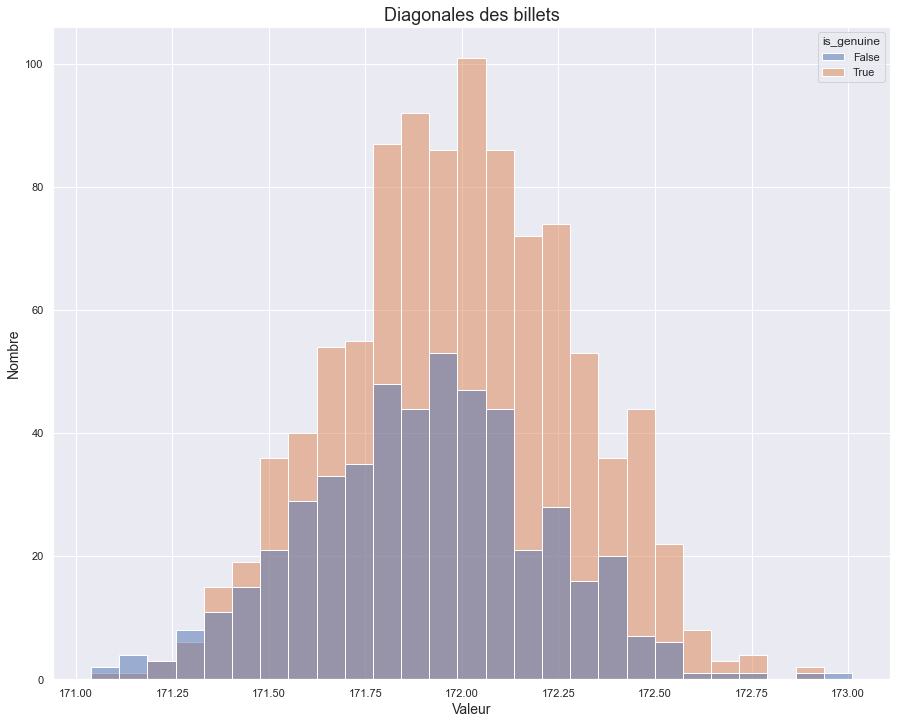

In [12]:
sns.histplot(x='diagonal',data= billet,hue='is_genuine')
plt.title('Diagonales des billets',fontsize = 18)
plt.xlabel('Valeur',fontsize = 14)
plt.ylabel('Nombre',fontsize = 14)
plt.show()

Comme indiqué via les légendes, la distribution en bleue représente les diagonales des faux billets et la distribution en rouge représente les diagonales des vrais billets.

Nous pouvons observer que ces deux distributions ont une forme de cloche, elles semblent dons suivre une loi de distribution Normale.

Cette information peut se révéler importante lors de la création des algorithmes.

Il est également à noter que nous avons quelques 'outliers' à l'extrémité droite du graphique, bien que cela semble être en quasi continuité avec le reste de la distribution.

Il s'agit donc très certainement de valeurs extrêmes que de valeurs aberrantes, donc nous allons garder ces valeurs.

En ce qui concerne les valeurs observées, nous ne pouvons pas voir de réelle différence entre les vrais et les faux billets :

    - les valeurs pour les faux billets sont comprises entre 171.04 et 173.01
    - les valeurs des vrais billets sont comprises entre 171.04 et 172.92

In [13]:
mean_f = billet.diagonal[billet.is_genuine == False].mean()
median_f = billet.diagonal[billet.is_genuine == False].median()
mean_t = billet.diagonal[billet.is_genuine == True].mean()
median_t = billet.diagonal[billet.is_genuine == True].median()

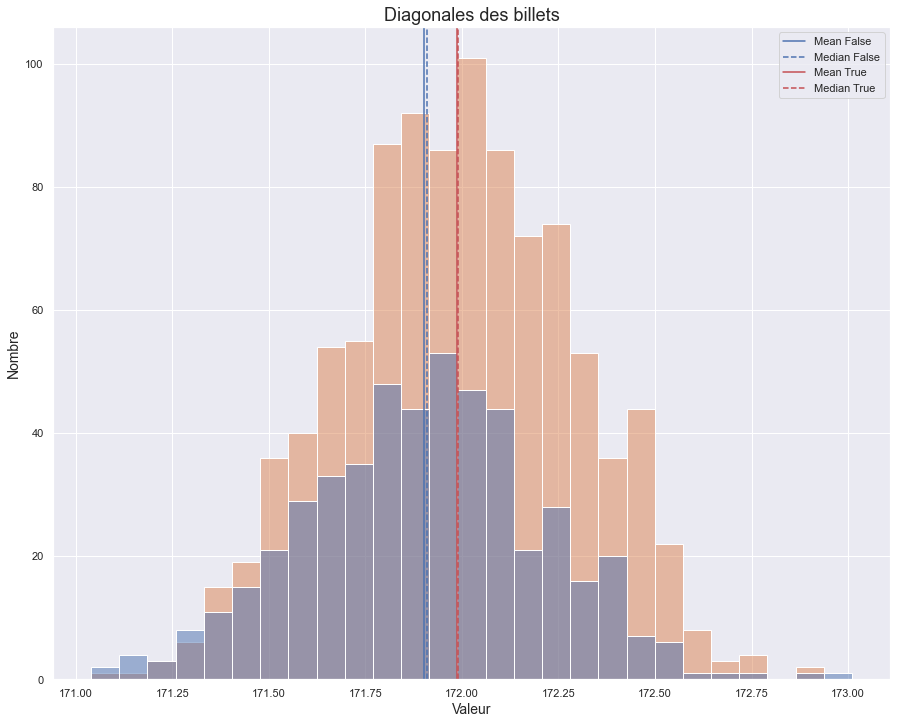

In [14]:
sns.histplot(x='diagonal',data= billet,hue='is_genuine')
plt.title('Diagonales des billets',fontsize = 18)
plt.xlabel('Valeur',fontsize = 14)
plt.ylabel('Nombre',fontsize = 14)
plt.axvline(mean_f,color='b',label='Mean False')
plt.axvline(median_f,color='b',label='Median False',linestyle='--')
plt.axvline(mean_t,color='r',label='Mean True')
plt.axvline(median_t,color='r',label='Median True',linestyle='--')
plt.legend()
plt.show()

Les différences peuvent être vues lorsque nous affichons les moyennes ainsi que les médianes des distributions :
   
   - Les vrais billets ont une moyenne et une médiane proche de 171.99
   - Les faux billets, quand à eux ont une moyenne et une médiane proche de 171.91

Nous pouvons constater que, dans les deux cas, la moyenne et la médiane se confondent, ce qui renforce l'hypothèse d'une distribution Normale.

Pour en revenir aux outliers, nous allons nous aider d'un nouveau type de graphes pour pouvoir mieux les détecter.

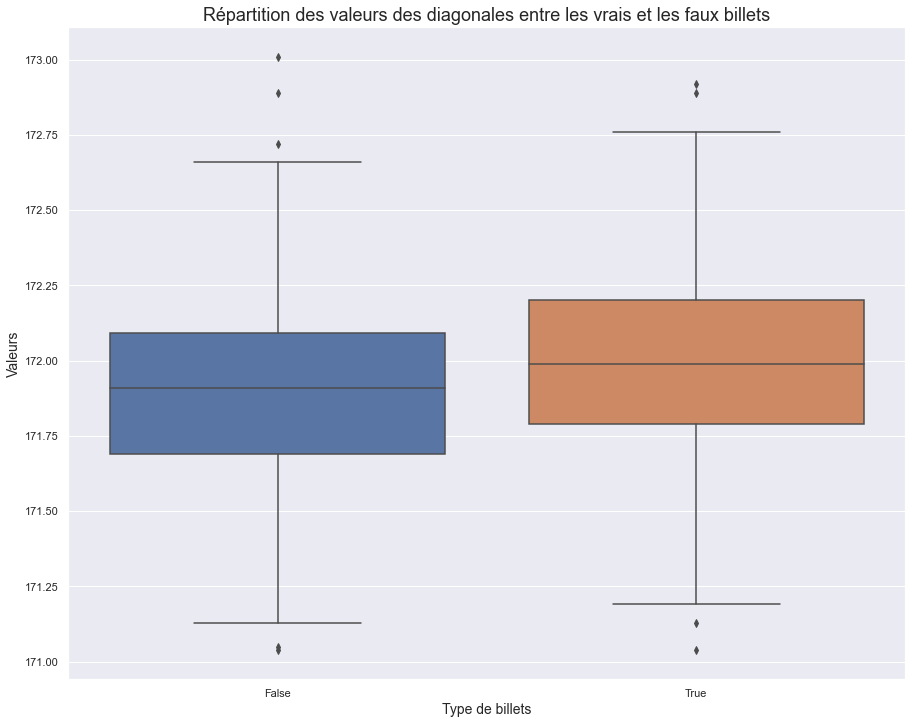

In [15]:
sns.boxplot(x = billet.is_genuine, y = billet.diagonal)
plt.title('Répartition des valeurs des diagonales entre les vrais et les faux billets',fontsize=18)
plt.xlabel('Type de billets',fontsize=14)
plt.ylabel('Valeurs',fontsize=14)
plt.show()

Ce graphe en boîte à moustache nous permet de détecter les outliers grâce à la méthode de l'écart inter-quartile.

Ce que nous pouvons voir est qu'il y a plus d'outliers que détecté sur les histogrammes, 4 pour les vrais billets et 5 pour les faux.

Nous allons toutefois garder notre première hypothèse, à savoir que ces outliers sont d'avantages des valeurs extrêmes que des valeurs aberrantes puisque ces valeurs sont quand même assez proches des valeurs 'normales'.

Nous allons toutefois stocker les données pour lesquels nous avons constater ces valeurs au cas où ces mêmes données présenteraient d'autres outliers pour les autres variables.

In [16]:
out_dia = billet[(billet.is_genuine==False)&(billet.diagonal>172.70)|(billet.is_genuine==False)&(billet.diagonal<171.10)|
                (billet.is_genuine==True)&(billet.diagonal>172.76)|(billet.is_genuine==True)&(billet.diagonal<171.15)]
out_dia

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
636,True,171.13,104.28,103.14,4.16,2.92,113.00
729,True,171.04,103.84,103.64,4.22,3.36,112.70
828,True,172.92,103.55,103.94,4.78,3.27,113.55
842,True,172.89,103.77,104.24,4.12,3.01,113.72
1022,False,172.89,104.03,104.03,6.03,3.00,110.95
1142,False,171.04,104.23,104.22,4.87,3.56,111.54
1277,False,173.01,104.59,104.31,5.04,3.05,110.91
1388,False,171.05,104.09,104.50,4.72,3.10,112.44
1450,False,172.72,104.05,104.17,4.21,3.37,111.53


## Distribution des valeurs des hauteurs gauches des billets

Nous allons maintenant passer à la distribution dans le cas de la variable 'height_left'.

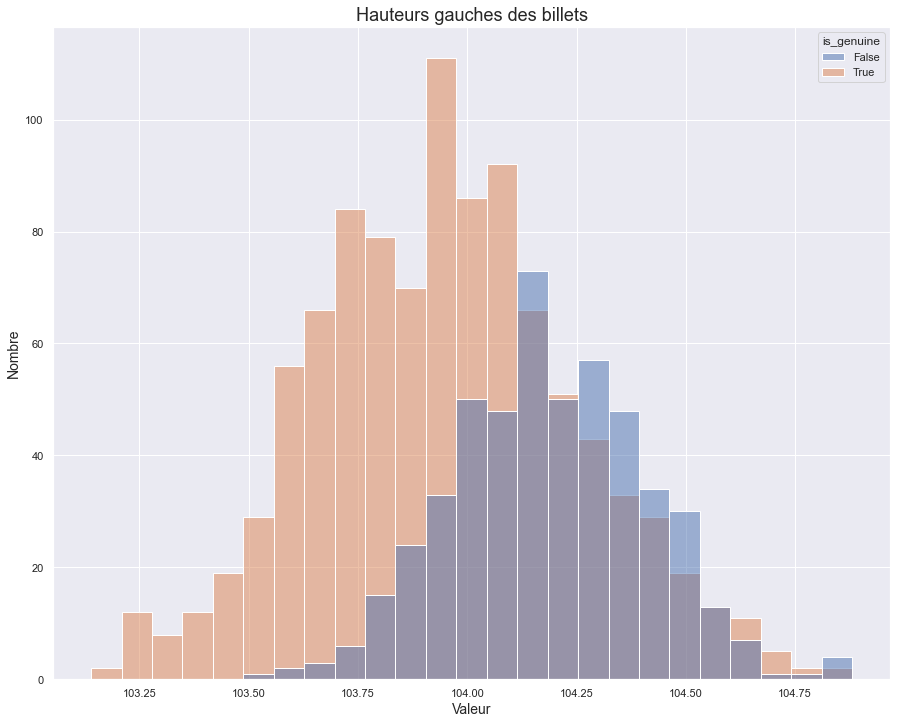

In [17]:
sns.histplot(x='height_left',data= billet,hue='is_genuine' )
plt.title('Hauteurs gauches des billets',fontsize = 18)
plt.xlabel('Valeur',fontsize = 14)
plt.ylabel('Nombre',fontsize = 14)
plt.show()

Ici également, nous pouvons constater deux distributions suivant une loi Normale.

Mais, contrairement au premier histogramme :

    - Nous ne constatons pas visuellement d'outliers
    - Nous remarquons des différences visuelles :
        - Les valeurs des faux billets sont comprises entre 103.51 et 104.88
        - Les valeurs des vrais billets sont comprises entre 103.14 et 104.86


Nous pouvons donc passer à la suite.

In [18]:
mean_f = billet.height_left[billet.is_genuine == False].mean()
median_f = billet.height_left[billet.is_genuine == False].median()
mean_t = billet.height_left[billet.is_genuine == True].mean()
median_t = billet.height_left[billet.is_genuine == True].median()

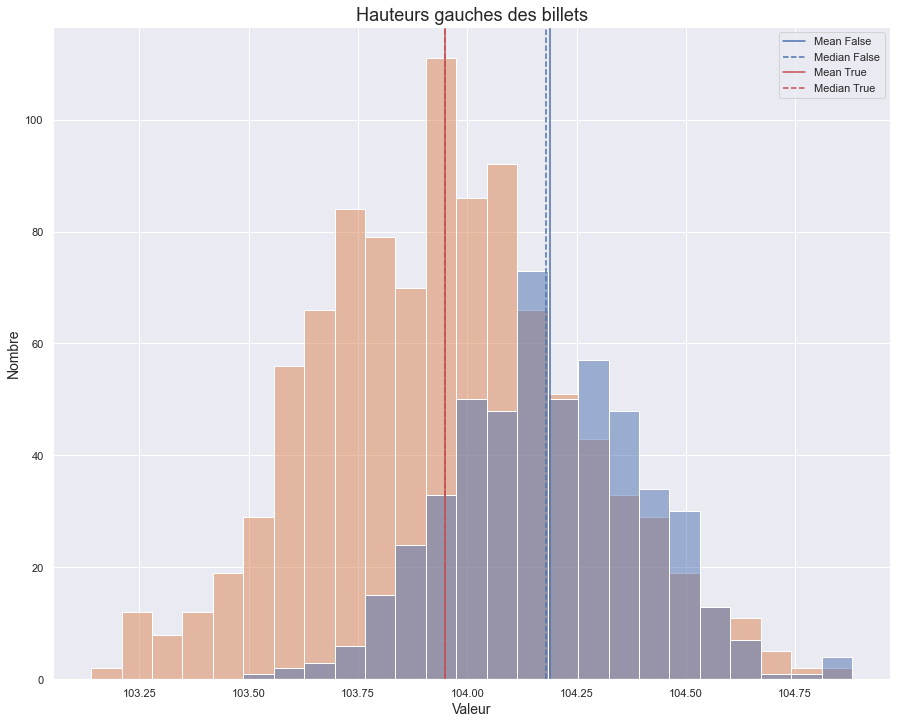

In [19]:
sns.histplot(x='height_left',data= billet,hue='is_genuine' )
plt.title('Hauteurs gauches des billets',fontsize = 18)
plt.xlabel('Valeur',fontsize = 14)
plt.ylabel('Nombre',fontsize = 14)
plt.axvline(mean_f,color='b',label='Mean False')
plt.axvline(median_f,color='b',label='Median False',linestyle='--')
plt.axvline(mean_t,color='r',label='Mean True')
plt.axvline(median_t,color='r',label='Median True',linestyle='--')
plt.legend()
plt.show()

Nous pouvons d'autant plus remarquer les différences entre les vrais et les faux billets avec ce graphique :

    - la moyenne et la médiane des valeurs des faux billets sont proche de 104.2
    - celles des vrais billets sont plus proche de 103.95

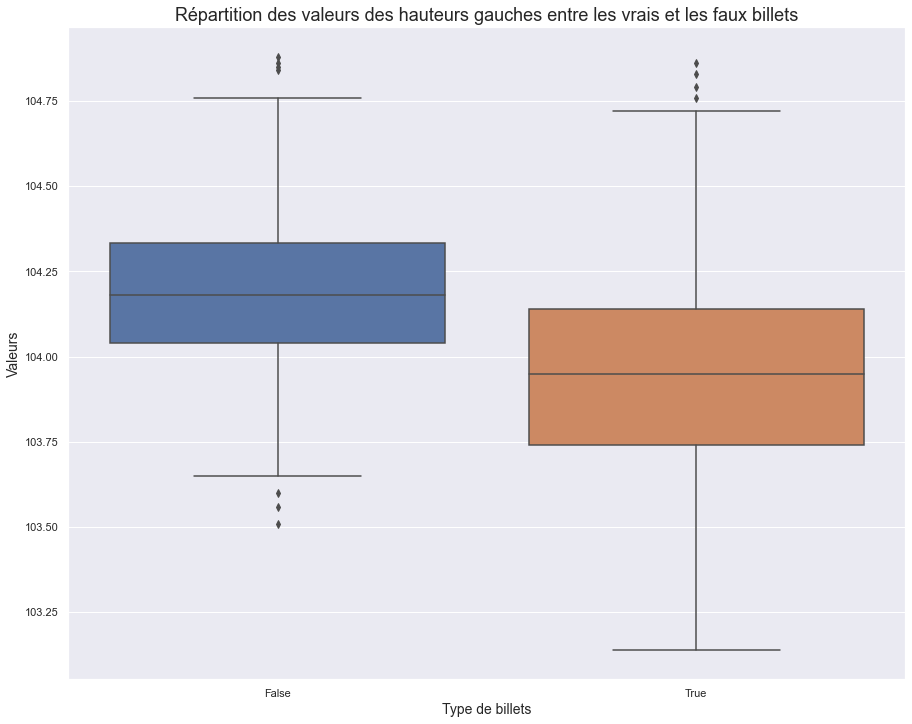

In [20]:
sns.boxplot(x = billet.is_genuine, y = billet.height_left)
plt.title('Répartition des valeurs des hauteurs gauches entre les vrais et les faux billets',fontsize=18)
plt.xlabel('Type de billets',fontsize=14)
plt.ylabel('Valeurs',fontsize=14)
plt.show()

Pour ce qui est des outliers, nous pouvons en voir bien plus que précédemment.

Ici aussi, ils s'enregistrent dans la continuité des valeurs 'normales', donc nous pouvons supposer que ce sont également des valeurs extrêmes.

Nous allons les laisser telles quelles tout en les stockant dans une nouvelle varaible au cas où.

In [21]:
out_hleft = billet[(billet.is_genuine==False)&(billet.height_left>104.76)|(billet.is_genuine==False)&(billet.height_left<103.63)|
                (billet.is_genuine==True)&(billet.height_left>104.73)]
out_hleft

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
491,True,172.60,104.83,103.56,4.10,2.94,113.38
905,True,171.99,104.76,104.55,4.39,3.02,113.70
965,True,171.42,104.79,104.16,3.45,3.16,112.64
1083,False,171.85,103.60,103.82,4.60,3.21,112.50
1085,False,171.39,103.51,103.50,5.52,3.45,111.54
1090,False,172.11,104.88,104.10,4.80,3.73,110.78
1150,False,171.79,104.86,104.34,5.39,3.14,113.02
1168,False,171.83,103.56,103.76,5.56,3.49,110.70
1310,False,171.92,104.84,104.60,5.96,2.92,110.69


In [22]:
pd.merge(out_hleft,out_dia)
# Cette commande permet de joindre les deux dataframes renseignées en utilisant les colonnes communes pour la jointure
# Seules les données étant présentes dans ces deux dataframes seront dans la nouvelle générée par cette commande

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length


Comme nous pouvons le constater, il n'y a aucun billet en commun en ce qui concerne les outliers des deux premières variables étudiées.

## Distribution des valeurs des hauteurs droites des billets

Nous passons maintenant à l'histogramme des valeurs des hauteurs à droite des billets.

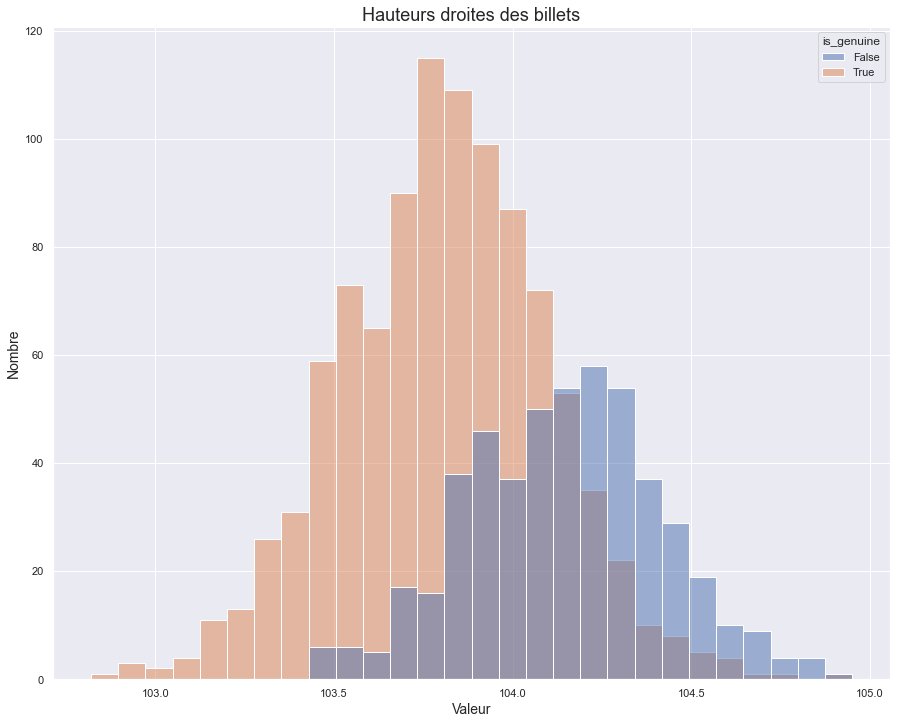

In [23]:
sns.histplot(x='height_right',data= billet,hue='is_genuine' )
plt.title('Hauteurs droites des billets',fontsize = 18)
plt.xlabel('Valeur',fontsize = 14)
plt.ylabel('Nombre',fontsize = 14)
plt.show()

Ici, nous observons un graphe assez similaire au graphe précédent représentant la distribution des valeurs des hauteurs gauches des billets.

Il semble qu'il y ai, encore une fois, deux distributions suivant une loi Normale, bien que pour les faux billets, c'est un peu moins évident.

En ce qui concerne l'étendue des valeurs, nous avons :

    - pour les vrais billets, des valeurs comprises entre 102.82 et 104.95
    - pour les faux billets, des valeurs comprises entre 103.43 et 104.95

Bien qu'il est difficile à discerner, nous pouvons voir un 'outlier' dans le cas des vrais billets à l'extrémité droite du graphe.

Nous allons créer un nouveau graphe de type boxplot pour confirmer (ou infirmer) la présence de cet outlier plus tard dans cette partie.

Nous allons maintenant passer à l'étude des moyennes et des médianes des deux distributions.

In [24]:
mean_f = billet.height_right[billet.is_genuine == False].mean()
median_f = billet.height_right[billet.is_genuine == False].median()
mean_t = billet.height_right[billet.is_genuine == True].mean()
median_t = billet.height_right[billet.is_genuine == True].median()

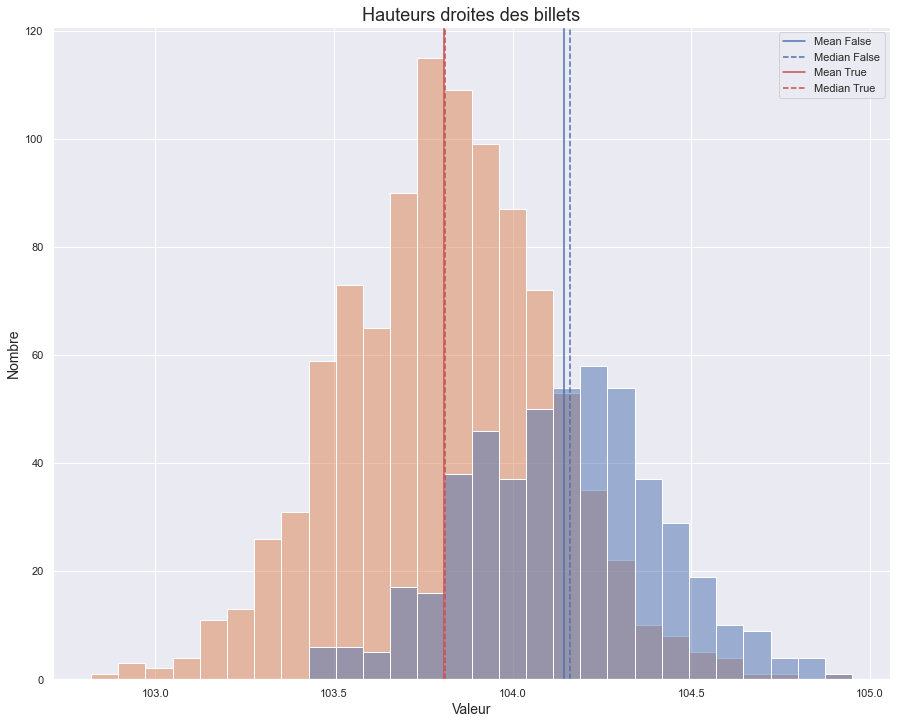

In [25]:
sns.histplot(x='height_right',data= billet,hue='is_genuine' )
plt.title('Hauteurs droites des billets',fontsize = 18)
plt.xlabel('Valeur',fontsize = 14)
plt.ylabel('Nombre',fontsize = 14)
plt.axvline(mean_f,color='b',label='Mean False')
plt.axvline(median_f,color='b',label='Median False',linestyle='--')
plt.axvline(mean_t,color='r',label='Mean True')
plt.axvline(median_t,color='r',label='Median True',linestyle='--')
plt.legend()
plt.show()

Nous pouvons voir qu'effectivement, les distributions suivent une loi Normale avec leur moyenne et leur médiane similaires.

En revanche, les distribution sont différentes l'une de l'autre puisque la moyenne et la médiane de la distribution rouge sont proches de 103.8 tandis que celles de la distribution bleue sont proches de 104.15.

Passons maintenant aux eventuels outliers que nous n'aurions pas détectés avec les histogrammes.

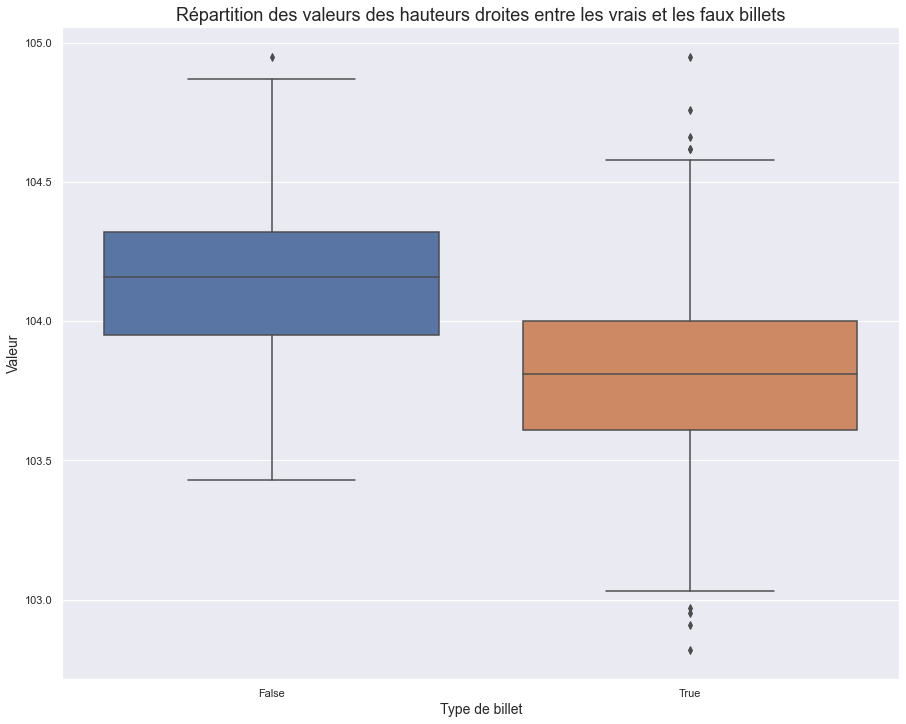

In [26]:
sns.boxplot(x='is_genuine',y='height_right',data= billet)
plt.title('Répartition des valeurs des hauteurs droites entre les vrais et les faux billets',fontsize = 18)
plt.xlabel('Type de billet',fontsize = 14)
plt.ylabel('Valeur',fontsize = 14)
plt.show()

Effectivement, nous avons des outliers qui n'étaient pas visibles sur les histogrammes au vu de leur valeur proche des valeurs normales.

Nous allons maintenant effectuer les mêmes opérations que précédement.

In [27]:
out_hright = billet[(billet.is_genuine==False)&(billet.height_right>104.9)|(billet.is_genuine==True)&(billet.height_right<103)|
                (billet.is_genuine==True)&(billet.height_right>104.6)]
out_hright

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
176,True,171.75,103.63,102.97,4.46,2.77,113.22
193,True,172.35,103.73,102.95,4.49,3.37,112.49
251,True,171.80,103.26,102.82,NaN,2.95,113.22
522,True,172.02,104.42,102.91,3.86,3.12,113.43
661,True,171.69,104.22,104.62,4.11,3.25,113.40
801,True,172.19,103.84,104.62,4.14,3.21,113.45
921,True,171.36,103.72,104.76,4.17,2.88,113.14
946,True,171.63,103.87,104.66,NaN,3.27,112.68
1484,False,172.08,103.96,104.95,5.22,3.45,112.07


In [28]:
pd.merge(out_dia,out_hright)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length


Nous voyons bien qu'il n'y a aucune donnée qui possède des outliers dans la variable 'diagonal' et dans la variable 'height_right'.

In [29]:
pd.merge(out_hleft,out_hright)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83


En revanche, nous voyons bien qu'il y a une donnée (donc un billet) qui possède une valeur extrême à la fois pour la variable 'height_left' et 'height_right'.

Nous allons stocker cette donnée ailleurs pour vérifier si elle possède d'autres valeurs extrêmes, auquel cas nous devrons surement l'exclure du dataframe pour la construction de nos algorithmes.

In [30]:
out = pd.merge(out_hleft,out_hright)

## Distribution des valeurs des marges inférieures des billets 

Il est important de rappeler qu'il s'agit de la variable dont il manque des valeurs.

Nous allons effectuer une première analyse descriptive ici puis une deuxième après avoir récupérer les valeurs manquantes avec la régression linéaire.

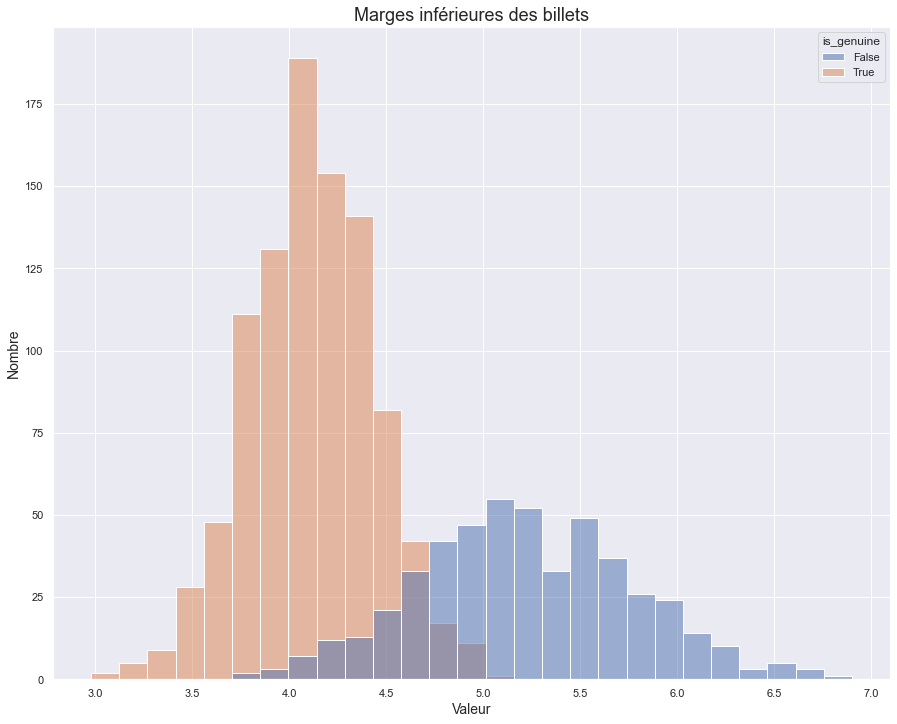

In [31]:
sns.histplot(x='margin_low',data= billet,hue='is_genuine' )
plt.title('Marges inférieures des billets',fontsize = 18)
plt.xlabel('Valeur',fontsize = 14)
plt.ylabel('Nombre',fontsize = 14)
plt.show()

Nous avons de nouveau deux distributions suivant à priori une loi Normale.

Les plages des valeurs sont :

    - de 3.82 à 6.9 pour les faux billets
    - de 2.98 à 5.04 pour les vrais billets

In [32]:
mean_f = billet.margin_low[billet.is_genuine == False].mean()
median_f = billet.margin_low[billet.is_genuine == False].median()
mean_t = billet.margin_low[billet.is_genuine == True].mean()
median_t = billet.margin_low[billet.is_genuine == True].median()

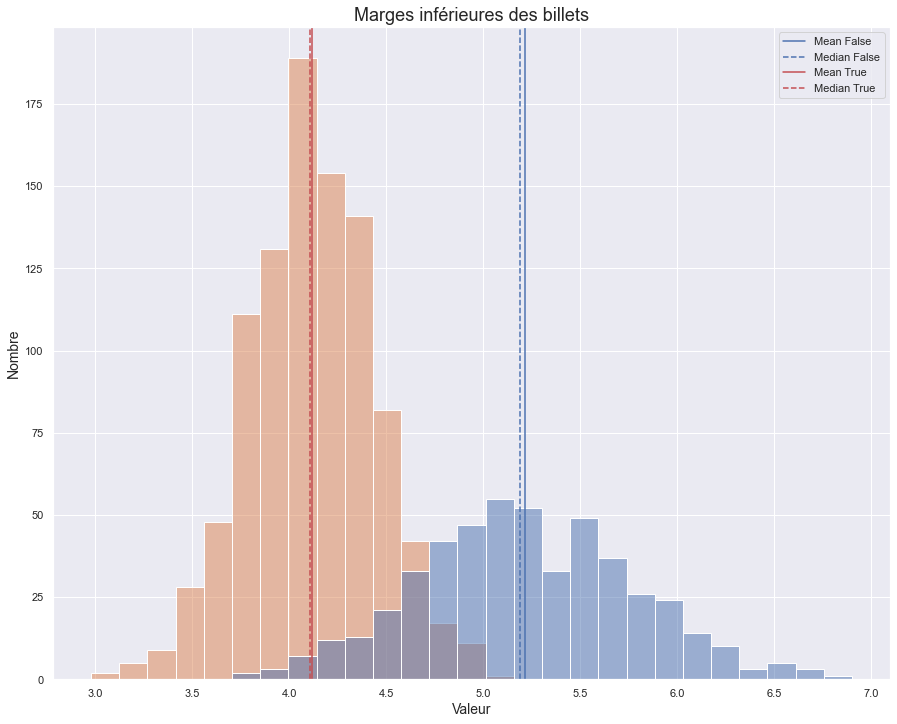

In [33]:
sns.histplot(x='margin_low',data= billet,hue='is_genuine' )
plt.title('Marges inférieures des billets',fontsize = 18)
plt.xlabel('Valeur',fontsize = 14)
plt.ylabel('Nombre',fontsize = 14)
plt.axvline(mean_f,color='b',label='Mean False')
plt.axvline(median_f,color='b',label='Median False',linestyle='--')
plt.axvline(mean_t,color='r',label='Mean True')
plt.axvline(median_t,color='r',label='Median True',linestyle='--')
plt.legend()
plt.show()

Ici, nous observons une similitude entre la moyenne et la médiane de chaque distribution, ce qui nous conforte dans notre idée que ces deux distributions suivent une loi Normale.


En ce qui concerne les valeurs, nous avons :

    - la moyenne et la médiane de la distribution rouge proches de 4.1
    - celles de la distribution bleue sont proches de 5.2

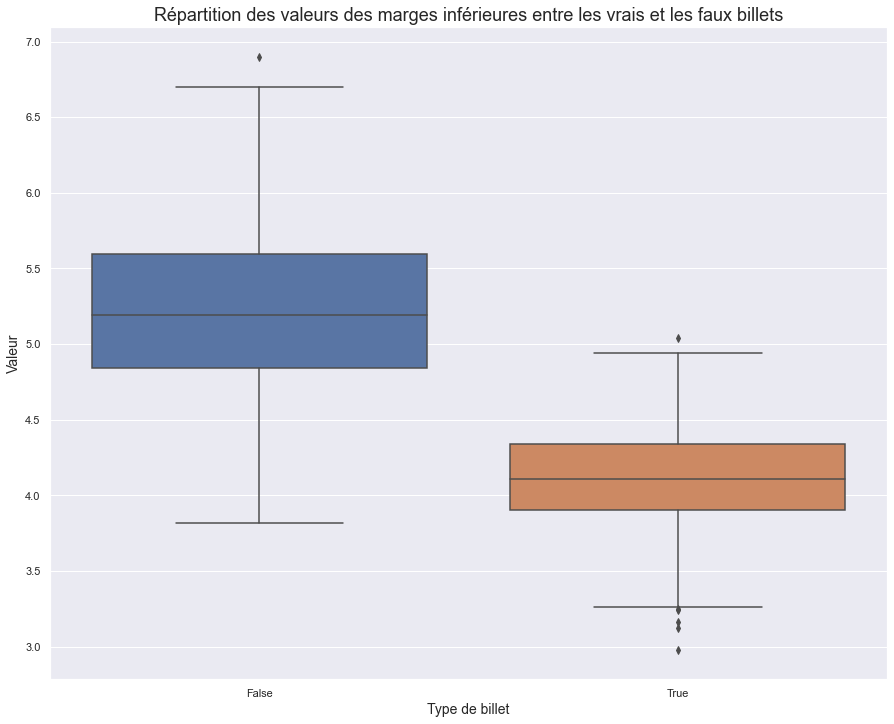

In [34]:
sns.boxplot(x='is_genuine',y='margin_low',data= billet)
plt.title('Répartition des valeurs des marges inférieures entre les vrais et les faux billets',fontsize = 18)
plt.xlabel('Type de billet',fontsize = 14)
plt.ylabel('Valeur',fontsize = 14)
plt.show()

Pour cette variable, il semble y avoir moins de outliers que pour les précédentes.

In [35]:
out_ml = billet[(billet.is_genuine==False)&(billet.margin_low>6.8)|(billet.is_genuine==True)&(billet.margin_low>5)|
               (billet.is_genuine==True)&(billet.margin_low<3.25)]
out_ml

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
10,True,171.83,104.14,103.62,3.16,3.18,113.22
477,True,171.95,104.25,103.64,3.24,2.81,113.42
664,True,172.05,103.70,103.75,5.04,2.27,113.55
788,True,171.99,103.67,103.76,3.12,2.99,113.22
897,True,172.00,103.65,103.83,2.98,2.76,113.17
1290,False,171.94,104.06,104.22,6.90,3.36,111.70


In [36]:
pd.merge(out,out_ml)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length


In [37]:
pd.merge(out_dia,out_ml)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length


In [38]:
pd.merge(out_hleft,out_ml)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length


In [39]:
pd.merge(out_hright,out_ml)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length


Grâce aux jointures ci-dessus, nous pouvons constater qu'aucune valeur extrême précédemment détectée n'est présente parmi celles de la variable 'margin_low'.

## Distribution des valeurs de la marge supérieure des billets

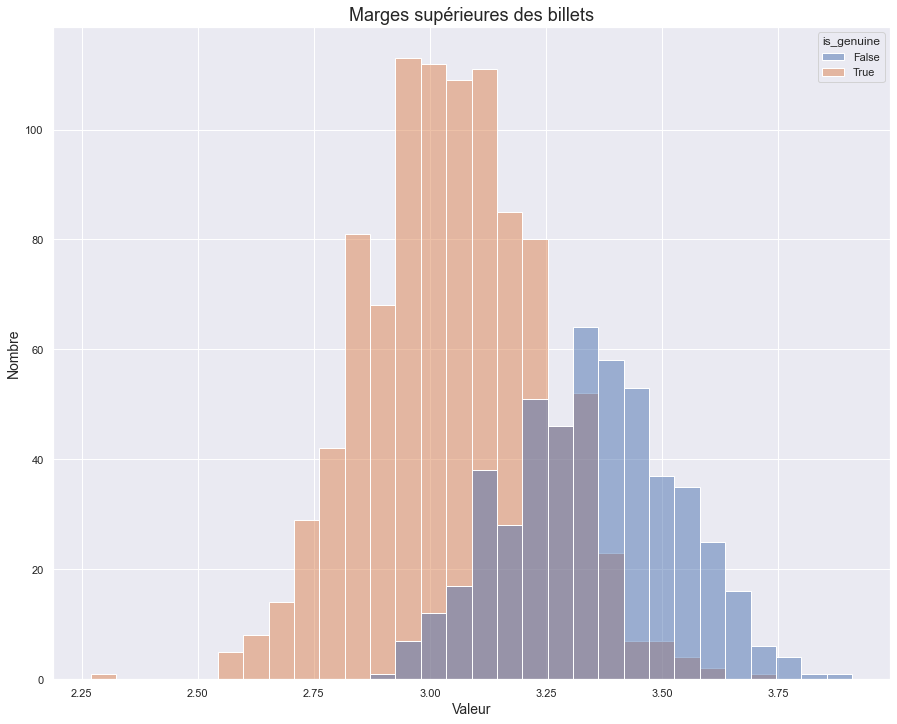

In [40]:
sns.histplot(x='margin_up',data= billet,hue='is_genuine')
plt.title('Marges supérieures des billets',fontsize = 18)
plt.xlabel('Valeur',fontsize = 14)
plt.ylabel('Nombre',fontsize = 14)
plt.show()

Nous retrouvons encore deux distributions en forme de cloche, ce qui suppose toujours une distribution suivant une loi Normale.

L'étendue des valeurs est de :

    - 2.27 à 3.74 pour les vrais billets
    - 2.92 à 3.91 pour les faux billets
    
    
Visuellement, nous pouvons détecter deux outliers pour la distribution des vrais billets, une à l'extrémité gauche du graphe et l'autre proche de la valeur 3.75, nous reviendrons dessus plus tard.

In [41]:
mean_f = billet.margin_up[billet.is_genuine == False].mean()
median_f = billet.margin_up[billet.is_genuine == False].median()
mean_t = billet.margin_up[billet.is_genuine == True].mean()
median_t = billet.margin_up[billet.is_genuine == True].median()

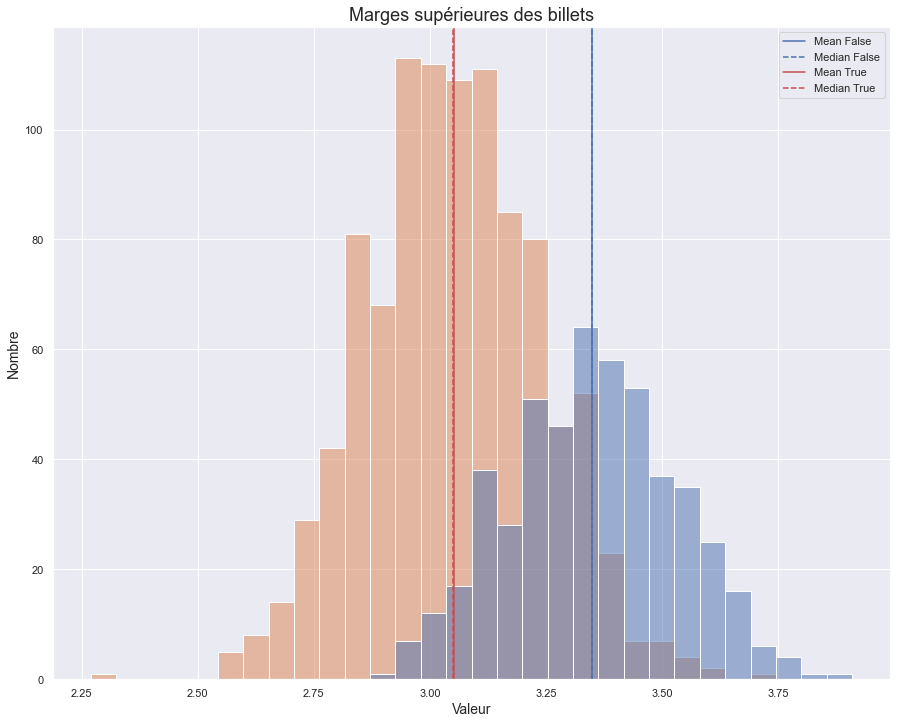

In [42]:
sns.histplot(x='margin_up',data= billet,hue='is_genuine' )
plt.title('Marges supérieures des billets',fontsize = 18)
plt.xlabel('Valeur',fontsize = 14)
plt.ylabel('Nombre',fontsize = 14)
plt.axvline(mean_f,color='b',label='Mean False')
plt.axvline(median_f,color='b',label='Median False',linestyle='--')
plt.axvline(mean_t,color='r',label='Mean True')
plt.axvline(median_t,color='r',label='Median True',linestyle='--')
plt.legend()
plt.show()

Là encore, nous retrouvons la moyenne et la médiane de chaque distribution proche l'une de l'autre, ce qui implique bien une distribution suivant une loi normale.


Les valeurs sont proches de :

    - 3.05 pour les vrais billets 
    - 3.35 pour les faux billets

Nous allons maintenant revenir sur les outliers détectés et voir s'il n'y en a pas d'autres pour cette variable.

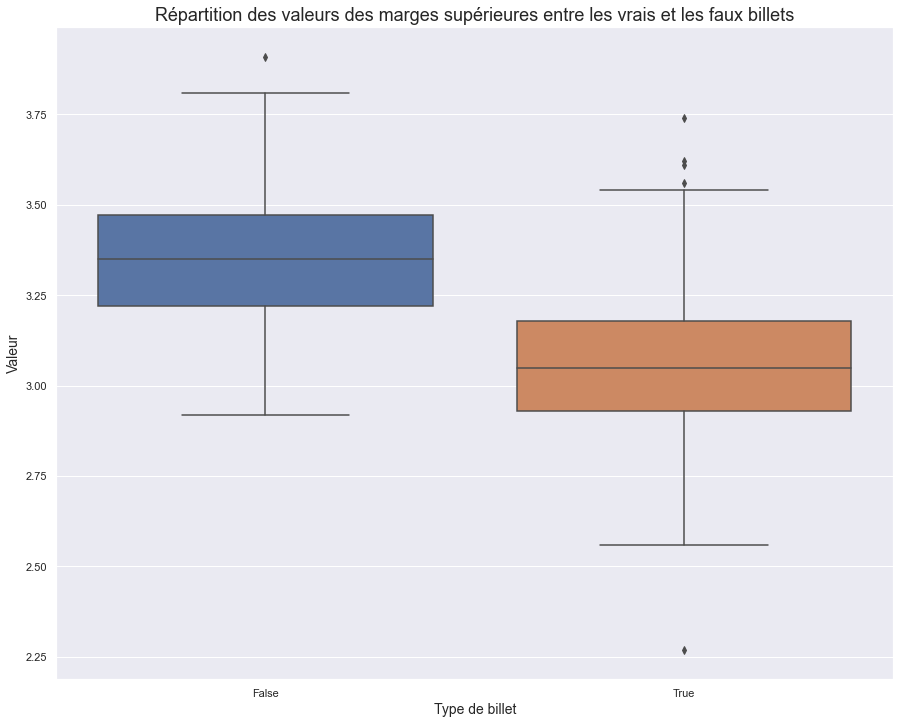

In [43]:
sns.boxplot(x='is_genuine',y='margin_up',data= billet)
plt.title('Répartition des valeurs des marges supérieures entre les vrais et les faux billets',fontsize = 18)
plt.xlabel('Type de billet',fontsize = 14)
plt.ylabel('Valeur',fontsize = 14)
plt.show()

Nous pouvons constater que l'une d'elle est loin des autres valeurs, nous pouvons supposer que dans ce cas-là il ne s'agit pas d'une valeur extrême mais bien d'une valeur aberrante a éliminer de notre dataframe.

Les autres outliers semblent, au contraire, proches des valeurs 'normales'.

In [44]:
out_ab = billet[(billet.is_genuine==True)&(billet.margin_up<2.5)]
out_ab

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
664,True,172.05,103.7,103.75,5.04,2.27,113.55


Nous allons laisser celà tel quel au cas où il y aurait d'autres valeurs aberrantes dans celles de la dernière variable à étudier.

In [45]:
out_mu = billet[(billet.is_genuine==True)&(billet.margin_up>3.55)|(billet.is_genuine==False)&(billet.margin_up>3.85)]
out_mu

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
48,True,172.07,104.05,103.82,3.71,3.61,113.05
52,True,171.64,104.18,103.78,3.49,3.74,113.94
197,True,171.45,103.66,103.80,NaN,3.62,113.27
980,True,172.12,104.08,104.49,4.09,3.56,113.50
1029,False,171.96,104.29,104.03,6.01,3.91,110.83


In [46]:
pd.merge(out,out_mu)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length


In [47]:
pd.merge(out_dia,out_mu)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length


In [48]:
pd.merge(out_hleft,out_mu)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length


In [49]:
pd.merge(out_hright,out_mu)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length


In [50]:
pd.merge(out_ml,out_mu)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length


Là encore, il n'y a aucune ligne de données en commun entre les différentes dataframes contenant les valeurs extrêmes des variables étudiées.

Nous allons faire de même avec la valeur aberrante.

In [51]:
pd.merge(out_ab,out_ml)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,172.05,103.7,103.75,5.04,2.27,113.55


Avec cette première jointure, nous comprenons que nous devrons effectivement supprimer cette ligne de données.

Passons maintenant au dernier histogramme.

## Distribution des valeurs de la hauteur des billets

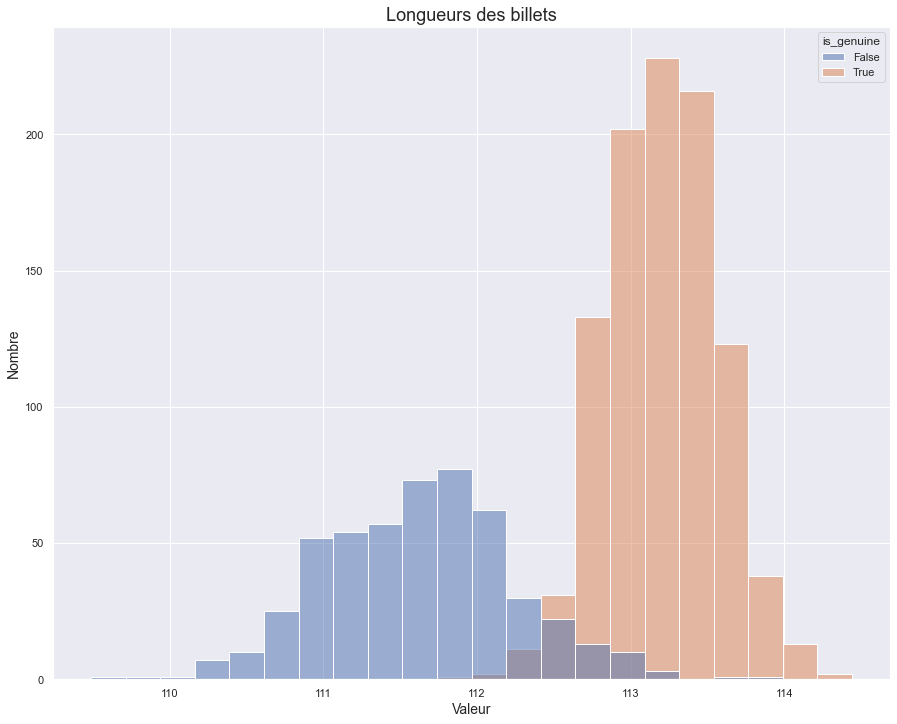

In [52]:
sns.histplot(x='length',data= billet,hue='is_genuine' )
plt.title('Longueurs des billets',fontsize = 18)
plt.xlabel('Valeur',fontsize = 14)
plt.ylabel('Nombre',fontsize = 14)
plt.show()

Les deux distributions semblent à priori suivre une loi Normale, et nous pouvons constater la présence d'outliers pour la distribution bleue.

Pour les plages de valeurs, nous avons :

    - de 109.5 à 113.85 pour les faux billets
    - de 111.76 à 114.44 pour les vrais billets

In [53]:
mean_f = billet.length[billet.is_genuine == False].mean()
median_f = billet.length[billet.is_genuine == False].median()
mean_t = billet.length[billet.is_genuine == True].mean()
median_t = billet.length[billet.is_genuine == True].median()

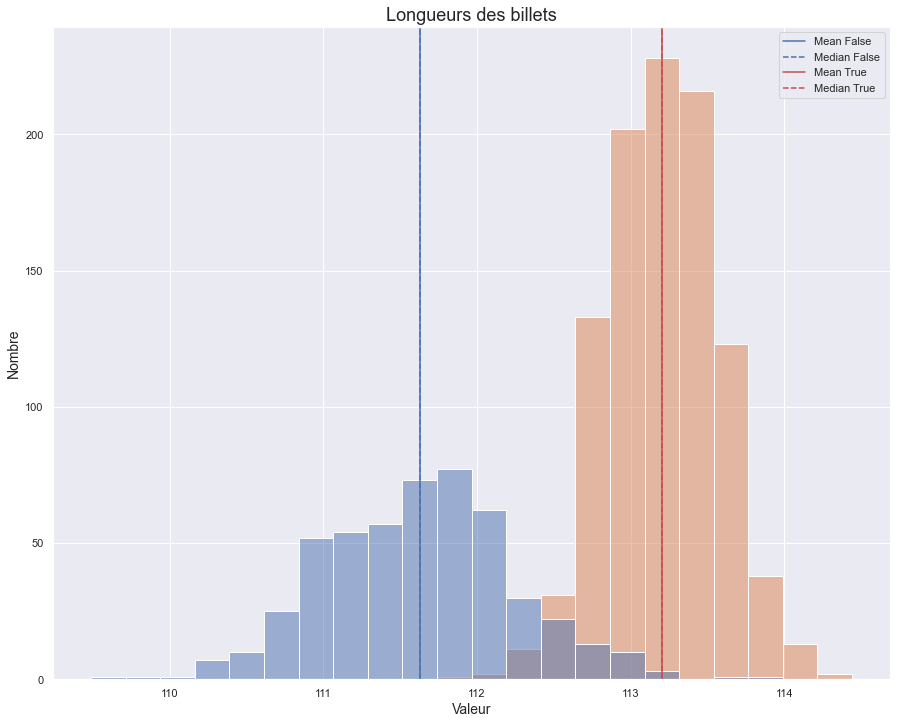

In [54]:
sns.histplot(x='length',data= billet,hue='is_genuine' )
plt.title('Longueurs des billets',fontsize = 18)
plt.xlabel('Valeur',fontsize = 14)
plt.ylabel('Nombre',fontsize = 14)
plt.axvline(mean_f,color='b',label='Mean False')
plt.axvline(median_f,color='b',label='Median False',linestyle='--')
plt.axvline(mean_t,color='r',label='Mean True')
plt.axvline(median_t,color='r',label='Median True',linestyle='--')
plt.legend()
plt.show()

Comme pour les autres histogrammes, nous pouvons continuer avec le fait que les distributions des billets suivent une loi Normale puisque la moyenne et la médiane de chaque distribution sont quasiment identiques.


Les valeurs sont proches de :

    - 113.2 pour la distribution rouge
    - 111.6 pour la distribution bleue

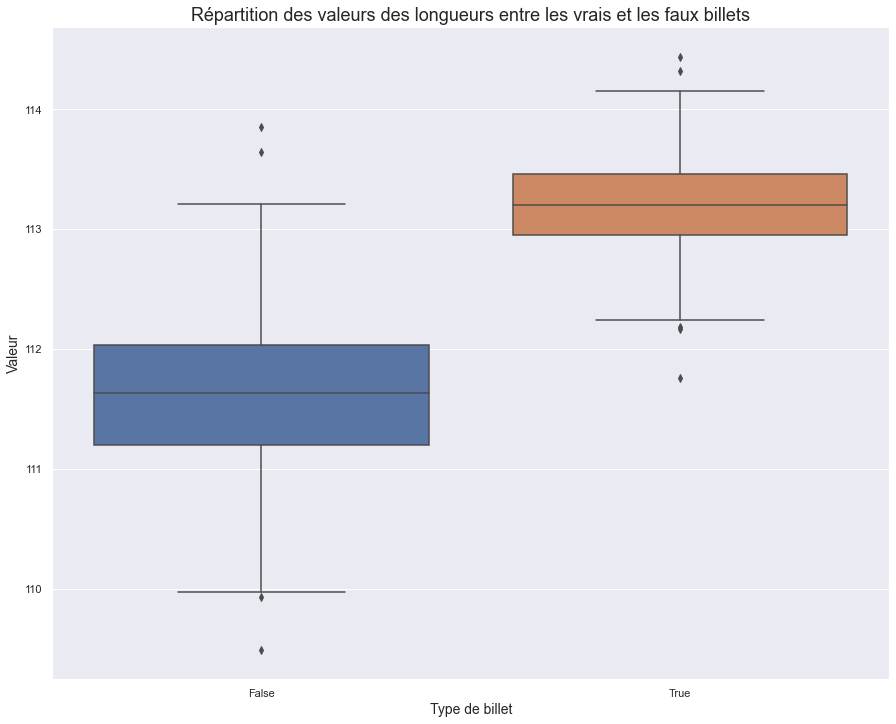

In [55]:
sns.boxplot(x='is_genuine',y='length',data= billet)
plt.title('Répartition des valeurs des longueurs entre les vrais et les faux billets',fontsize = 18)
plt.xlabel('Type de billet',fontsize = 14)
plt.ylabel('Valeur',fontsize = 14)
plt.show()

Nous pouvons observer quatre outlliers pour chaque distribution, qui sont d'avantage des valeurs extrêmes qu'aberrantes puisque leur valeur est proche des valeurs 'normale'.

In [56]:
out_len = billet[(billet.is_genuine==False)&(billet.length>113.5)|(billet.is_genuine==False)&(billet.length<109.95)|
                 (billet.is_genuine==True)&(billet.length>114.3)|(billet.is_genuine==True)&(billet.length<112.2)]
out_len

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
591,True,171.67,103.81,103.76,4.59,3.30,112.18
728,True,171.94,104.11,104.16,4.08,3.35,111.76
798,True,171.96,103.84,103.62,NaN,3.01,114.44
951,True,171.95,103.86,103.80,4.51,2.87,112.17
974,True,172.06,104.08,103.47,4.47,2.97,114.32
1082,False,171.75,103.96,103.83,5.39,3.54,109.49
1122,False,172.09,104.15,104.17,4.15,3.40,113.85
1325,False,171.83,104.39,104.17,5.51,3.33,113.64
1453,False,171.55,104.20,104.49,5.42,3.54,109.93


In [57]:
pd.merge(out,out_len)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length


In [58]:
pd.merge(out_dia,out_len)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length


In [59]:
pd.merge(out_hleft,out_len)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length


In [60]:
pd.merge(out_hright,out_len)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length


In [61]:
pd.merge(out_ml,out_len)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length


In [62]:
pd.merge(out_mu,out_len)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length


In [63]:
pd.merge(out_ab, out_len)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length


Nous voyons bien qu'il n'y a aucune ligne de données en commun entre les outliers des variables étudiées précédement et les outliers de la variable 'length'.

Il en va de même entre cette variable et la dataframe des valeurs aberrantes.

Nous n'avons donc une seule ligne de données à supprimer.

In [64]:
billet = billet.drop(out_ab.index,axis=0)
billet

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...,...
1495,False,171.75,104.38,104.17,4.42,3.09,111.28
1496,False,172.19,104.63,104.44,5.27,3.37,110.97
1497,False,171.80,104.01,104.12,5.51,3.36,111.95
1498,False,172.06,104.28,104.06,5.17,3.46,112.25


Pour conclure cette partie, nous avons remarqué suffisament de différence dans les caractéristiques entre les vrais et les faux billets pour pouvoir élaborer un algorithme assez performant.

## Répartition des billets

Nous allons maintenant regarder la répartition du jeu de données entre les vrais et les faux billets

In [65]:
true = billet.is_genuine[billet.is_genuine == True].count()
false = billet.is_genuine[billet.is_genuine == False].count()

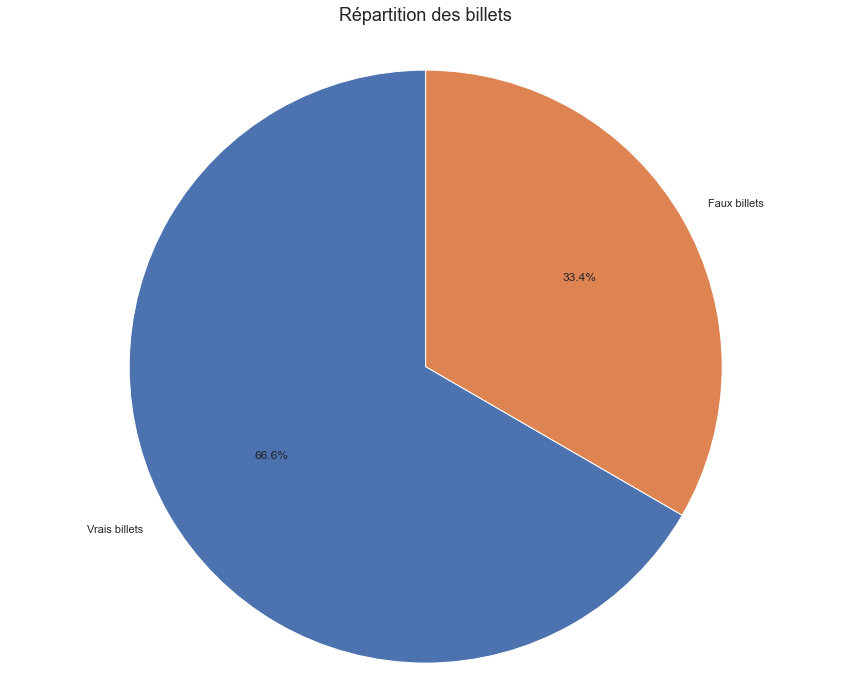

In [66]:
labels = 'Vrais billets', 'Faux billets'
# Etiquettes des différentes parts de notre graphique

sizes = [true, false]
# Tailles de chaque part de notre graphique

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
# Création du graphique avec les spécificités prédéfinies

plt.title('Répartition des billets', fontsize = 18, pad=20)
# Titre du graphique

plt.axis('equal')
# Permet de faire en sort que la forme finale soit bien un cercle

plt.show()

Nous avons 66.6 % de vrais billets soit deux tiers du jeu de données et 33.4 % de faux billets donc un tier du jeu de données.

# Régression linéaire

L'objectif initial d'une régression linéaire quelle qu'elle soit, est d'expliquer une variable quantitative y (dans notre cas 'margin_low') par rapport à une ou plusieurs variables quantitatives dites explicatives X.

Le but du jeu ici est de trouver une équation de droite telle que :

$ Y = b + \sum\limits _{i = 1} ^{p} a_{i}\times X_{i}$

avec p le nombre de variables explicatives

Pour la régression linéaire, nous avons plusieurs choix.

Nous pouvons :

    - faire simple et effectuer une régression linéaire simple (donc avec une seule variable explicative)
    - faire une régression linéaire multiple pour gagner en précision

Dans le premier cas, il suffira juste de choisir la variable qui explique le mieux la variable 'margin_low'.

Dans le second cas, il faudra choisir la régression en fonction de la corrélation entre les variables.

Si elles sont très fortement corrélées entre elles alors il y aura un niveau d'incertitude des paramètres si nous effectuons une régression linéaire multiple classique.

Dans ce cas, il faudra mieux opter pour une régression Lasso ou Ridge.

## Régression linéaire simple

In [67]:
import numpy as np
from sklearn.linear_model import LinearRegression

Nous allons créer plusieurs modèles de régressions linéaires simple pour pouvoir choisir la variable la plus à même d'expliquer 'margin_low'.

Nous allons également voir si le fait de séparer les billets entre faux et vrais a une incidense sur le modèle.

### Régression en séparant les vrais des faux billets

In [68]:
billet_t = billet[(billet.is_genuine==True)&(billet.margin_low.notnull())]
billet_f = billet[(billet.is_genuine==False)&(billet.margin_low.notnull())]

Nous pouvons maintenant passer aux régressions.

#### Régression avec la diagonale comme variable explicative

In [69]:
# On transforme les colonnes en array
x = np.array(billet_t['diagonal'])
y = np.array(billet_t['margin_low'])

# On doit transformer la forme des vecteurs pour qu'ils puissent être
# utilisés par Scikit learn

x = x.reshape(-1,1)
y = y.reshape(-1,1)

In [70]:
lr_dia = LinearRegression()

In [71]:
lr_dia.fit(x,y)

LinearRegression()

In [72]:
lr_dia.score(x,y)

0.0014477683842676337

Pour la première variable explicative, nous avons un coefficient de détermination proche de 0. 

Autrement dit, ce modèle n'explique pas la variable 'margin_low'.

Nous ne pourrons donc pas retrouver nos données perdues avec.

#### Régression avec la hauteur gauche des billets comme variable explicative

In [73]:
# On transforme les colonnes en array
x = np.array(billet_t['height_left'])
y = np.array(billet_t['margin_low'])

# On doit transformer la forme des vecteurs pour qu'ils puissent être
# utilisés par Scikit learn

x = x.reshape(-1,1)
y = y.reshape(-1,1)

In [74]:
lr_hl = LinearRegression()

In [75]:
lr_hl.fit(x,y)

LinearRegression()

In [76]:
lr_hl.score(x,y)

8.521038744424558e-05

Ici aussi, nous avons un coefficient de détermination très proche de 0.

Passons au modèle suivant.

#### Régression avec la hauteur droite des billets comme variable explicative

In [77]:
# On transforme les colonnes en array
x = np.array(billet_t['height_right'])
y = np.array(billet_t['margin_low'])

# On doit transformer la forme des vecteurs pour qu'ils puissent être
# utilisés par Scikit learn

x = x.reshape(-1,1)
y = y.reshape(-1,1)

In [78]:
lr_hr = LinearRegression()

In [79]:
lr_hr.fit(x,y)

LinearRegression()

In [80]:
lr_hr.score(x,y)

0.0014527696324238004

Ici aussi, nous avons un coefficient de détermination proche de 0.

Passons au modèle suivant.

#### Régression avec la marge supérieure des billets comme variable explicative

In [81]:
# On transforme les colonnes en array
x = np.array(billet_t['margin_up'])
y = np.array(billet_t['margin_low'])

# On doit transformer la forme des vecteurs pour qu'ils puissent être
# utilisés par Scikit learn

x = x.reshape(-1,1)
y = y.reshape(-1,1)

In [82]:
lr_mu = LinearRegression()

In [83]:
lr_mu.fit(x,y)

LinearRegression()

In [84]:
lr_mu.score(x,y)

0.0023554407799488697

Ici aussi, nous avons un coefficient de détermination proche de 0.

Passons au modèle suivant.

#### Régression avec la longueur des billets comme variable explicative

In [85]:
# On transforme les colonnes en array
x = np.array(billet_t['length'])
y = np.array(billet_t['margin_low'])

# On doit transformer la forme des vecteurs pour qu'ils puissent être
# utilisés par Scikit learn

x = x.reshape(-1,1)
y = y.reshape(-1,1)

In [86]:
lr_len = LinearRegression()

In [87]:
lr_len.fit(x,y)

LinearRegression()

In [88]:
lr_len.score(x,y)

0.0012946195673905203

Comme nous pouvons le constater, aucun modèle n'explique la variable 'margin_low' si nous séparons les vrais des faux billets avec leur R² étant proche de 0.

Nous allons tenter de regarder avec tout le jeu de données.

### Régression sans séparation

In [89]:
billet_nn = billet[billet.margin_low.notnull()]

#### Régression avec la diagonale comme variable explicative

In [90]:
# On transforme les colonnes en array
x = np.array(billet_nn['diagonal'])
y = np.array(billet_nn['margin_low'])

# On doit transformer la forme des vecteurs pour qu'ils puissent être
# utilisés par Scikit learn

x = x.reshape(-1,1)
y = y.reshape(-1,1)

In [91]:
lr_dia = LinearRegression()

In [92]:
lr_dia.fit(x,y)

LinearRegression()

In [93]:
lr_dia.score(x,y)

0.012484469560522737

Nous avons un coefficient de détermination proche de 0.

Passons au modèle suivant.

#### Régression avec la hauteur gauche des billets comme variable explicative

In [94]:
# On transforme les colonnes en array
x = np.array(billet_nn['height_left'])
y = np.array(billet_nn['margin_low'])

# On doit transformer la forme des vecteurs pour qu'ils puissent être
# utilisés par Scikit learn

x = x.reshape(-1,1)
y = y.reshape(-1,1)

In [95]:
lr_hl = LinearRegression()

In [96]:
lr_hl.fit(x,y)

LinearRegression()

In [97]:
lr_hl.score(x,y)

0.09209652539654356

Ici aussi, nous avons un coefficient de détermination proche de 0.

Passons au modèle suivant.

#### Régression avec la hauteur droite des billets comme variable explicative

In [98]:
# On transforme les colonnes en array
x = np.array(billet_nn['height_right'])
y = np.array(billet_nn['margin_low'])

# On doit transformer la forme des vecteurs pour qu'ils puissent être
# utilisés par Scikit learn

x = x.reshape(-1,1)
y = y.reshape(-1,1)

In [99]:
lr_hr = LinearRegression()

In [100]:
lr_hr.fit(x,y)

LinearRegression()

In [101]:
lr_hr.score(x,y)

0.1532864614988103

Ici, nous avons un coefficient de détermination proche de 0,15 ce qui nous indique que ce modèle explique un peu la variable 'margin_low'.

Passons au modèle suivant.

#### Régression avec la marge supérieure des billets comme variable explicative

In [102]:
# On transforme les colonnes en array
x = np.array(billet_nn['margin_up'])
y = np.array(billet_nn['margin_low'])

# On doit transformer la forme des vecteurs pour qu'ils puissent être
# utilisés par Scikit learn

x = x.reshape(-1,1)
y = y.reshape(-1,1)

In [103]:
lr_mu = LinearRegression()

In [104]:
lr_mu.fit(x,y)

LinearRegression()

In [105]:
lr_mu.score(x,y)

0.19015412523743946

Ce modèle explique un peu mieux la variable 'margin_low' que le modèle précédent.

Regardons à présent pour la dernière variable.

#### Régression avec la longueur des billets comme variable explicative

In [106]:
# On transforme les colonnes en array
x = np.array(billet_nn['length'])
y = np.array(billet_nn['margin_low'])

# On doit transformer la forme des vecteurs pour qu'ils puissent être
# utilisés par Scikit learn

x = x.reshape(-1,1)
y = y.reshape(-1,1)

In [107]:
lr_len = LinearRegression()

In [108]:
lr_len.fit(x,y)

LinearRegression()

In [109]:
lr_len.score(x,y)

0.4458421546743295

Ce dernier modèle explique déjà beaucoup mieux la variable 'margin_low' que les modèles précédents.

Voici une représentation graphique du modèle :

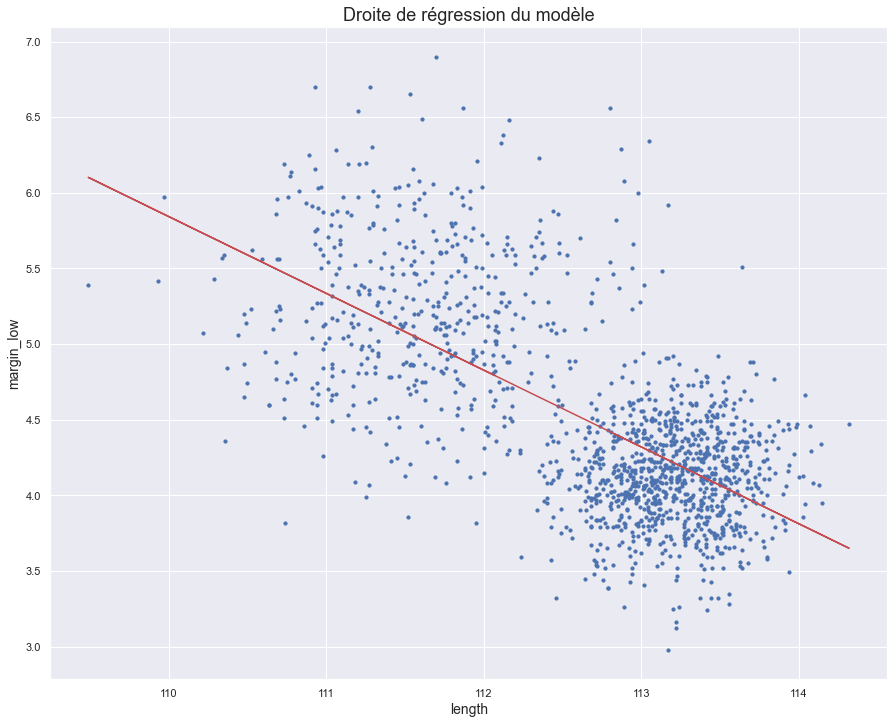

In [110]:
# Prédiction
y_predicted = lr_len.predict(x)

# Tracé des valeurs
# Points de données
plt.scatter(x, y, s=10)
plt.title('Droite de régression du modèle', fontsize = 18)
plt.xlabel('length', fontsize = 14)
plt.ylabel('margin_low', fontsize = 14)

# Valeurs prédites
plt.plot(x, y_predicted, color='r')
plt.show()

Cependant, nous devons nous assurer que ce modèle est valide.

Pour ce faire, nous allons tester la normalité des résidus, ie est-ce que les erreurs entre les observations et les prédictions suivent une loi Normale de distribution ?

Il ne faut pas oublier que nous devrons faire deux tests différents pour les vrais et les faux billets puisque, comme nous l'avons vu lors des analyses de nos variables, leurs valeurs suivent une loi Normale de distribution lorsque nous différencions les vrais des faux billets.

In [111]:
from scipy.stats import shapiro

In [112]:
resid = y - y_predicted
billet_nn['resid_simple'] = resid

C:\Users\Elenweii\AppData\Local\Temp\ipykernel_15184\1769565758.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  billet_nn['resid_simple'] = resid


In [113]:
shapiro(billet_nn.resid_simple[billet_nn.is_genuine==True]).pvalue

0.33051371574401855

In [114]:
shapiro(billet_nn.resid_simple[billet_nn.is_genuine==False]).pvalue

0.32107672095298767

In [115]:
mean_f = billet_nn.resid_simple[billet_nn.is_genuine == False].mean()
median_f = billet_nn.resid_simple[billet_nn.is_genuine == False].median()
mean_t = billet_nn.resid_simple[billet_nn.is_genuine == True].mean()
median_t = billet_nn.resid_simple[billet_nn.is_genuine == True].median()

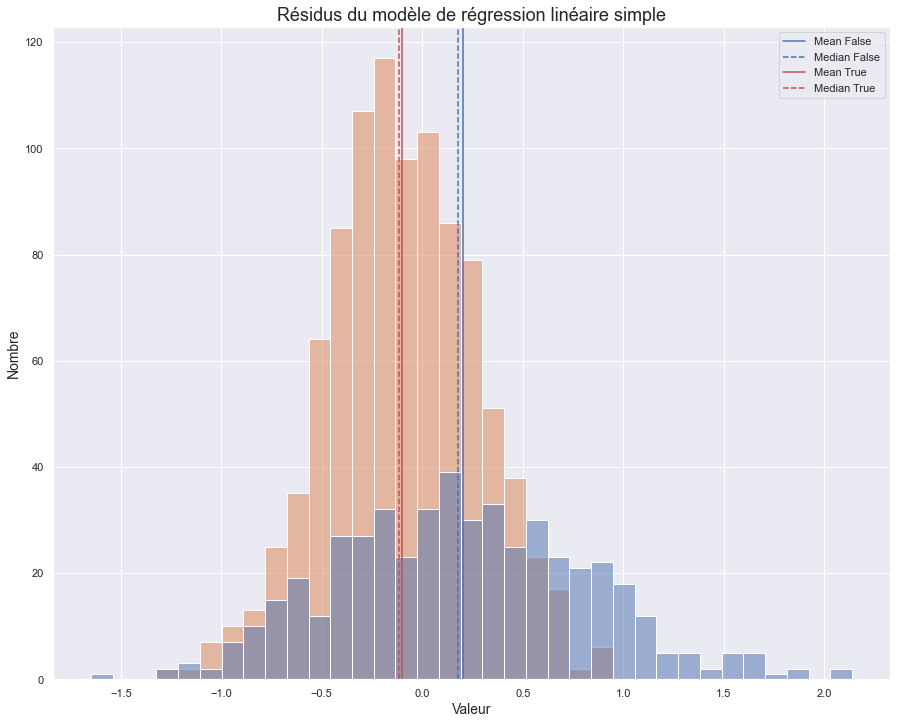

In [116]:
sns.histplot(x='resid_simple',data= billet_nn,hue='is_genuine' )
plt.title('Résidus du modèle de régression linéaire simple',fontsize = 18)
plt.xlabel('Valeur',fontsize = 14)
plt.ylabel('Nombre',fontsize = 14)
plt.axvline(mean_f,color='b',label='Mean False')
plt.axvline(median_f,color='b',label='Median False',linestyle='--')
plt.axvline(mean_t,color='r',label='Mean True')
plt.axvline(median_t,color='r',label='Median True',linestyle='--')
plt.legend()
plt.show()

Au vu de la p-valeur supérieure à 0.05 pour les deux catégories de billets, nous pouvons affirmer que les résidus suivent une loi Normale de distribution.

Ce qui implique, pour notre modèle, que celui-ci est valide.

Et effectivement, en regardant le graphique de la distribution, nous pouvons constater que les deux distributions ont une forme de cloche caractéristique de la loi Normale et avec leur médiane et leur moyenne proche l'une de l'autre dans les deux cas.

En conclusion, ce modèle est le plus performant que nous puissions avoir en régression linéaire simple.

Nous allons maintenant passer aux régressions linéaires multiples.

## Régression linéaire multiple

Avant toute chose, il faut déterminer si toutes variables explicatives sont corrélées entre elles, pour ce faire, nous allons réaliser une heatmap.

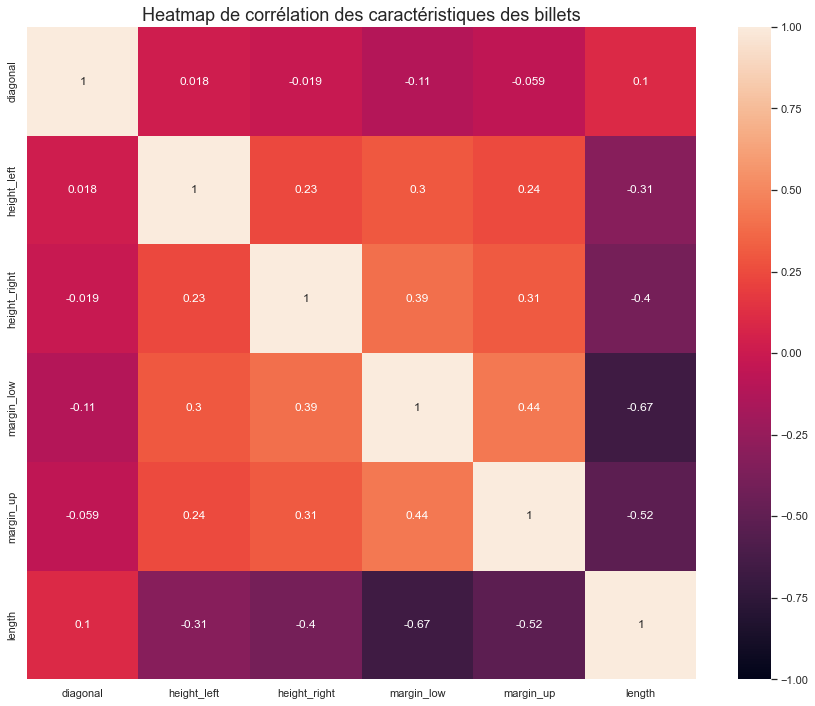

In [117]:
sns.heatmap(billet_nn.iloc[:,1:-1].corr(), vmin=-1, vmax=1, annot=True)
plt.title('Heatmap de corrélation des caractéristiques des billets', fontsize= 18)
plt.show()

Grâce à cette carte, nous pouvons voir qu'il existe beaucoup de corrélations entre les variables explicatives, nous allons d'abord orienter nos recherches sur une régression Ridge ou Lasso puis nous poursuivrons avec le modèle de régression linéaire multiple classique, voir s'il est plus performant.

### Pourquoi nous laissons de côté la Régression Ridge ?

Elle est particulièrement indiquée dans le cas où le jeu de données possède énormement de variables par rapport aux lignes de données et que ces variables explicatives sont fortement corrélées.

Or ici, nous n'avons que 5 variables explicatives pour 1499 lignes de données.

De ce fait, nous allons essayer une régression Lasso.

### Régression Lasso

Nous utilisons Lasso lorsque nous souhaitons faire une 'sélection' des covariables (ie si des variables sont très fortement corrélées, le modèle va choisir une variable parmi elles et ne garder que son coefficient).

A partir de ce point, nous allons reprendre les dataframes que nous avons crées pour la régression ridge.

In [118]:
from sklearn.linear_model import LassoCV

Ici aussi, nous allons tenter de le faire en séparant les billets entre vrais et faux.

In [119]:
X_f = billet_f.iloc[:,1:]
X_f = X_f.drop('margin_low',axis=1)
y_f = billet_f.iloc[:,-3]
X_t = billet_t.iloc[:,1:]
X_t = X_t.drop('margin_low',axis=1)
y_t = billet_t.iloc[:,-3]

In [120]:
lasso_f = LassoCV().fit(X_f,y_f)
lasso_f.score(X_f, y_f)

0.026627208178483408

Au vu des scores proches de 0, nous allons donc repasser sur le jeu de données en entier.

In [121]:
X = billet_nn.iloc[:,1:-1]
X = X.drop('margin_low',axis=1)
y = billet_nn.iloc[:,-4]

In [122]:
lasso = LassoCV().fit(X,y)
lasso.score(X,y)

0.4795420889245806

Ce coefficient de détermination étant légèrement meilleur que la régression linéaire simple, nous pouvons partir sur celui-ci pour retrouver nos données si, comme nous nous attendons à avoir (puisque,pour rappel, les variables sont corrélées), le prochain modèle explique moins bien la variable 'margin_low'.

In [123]:
y_predicted = lasso.predict(X)
resid = y - y_predicted
billet_nn['resid_lasso'] = resid

C:\Users\Elenweii\AppData\Local\Temp\ipykernel_15184\4137740719.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  billet_nn['resid_lasso'] = resid


In [124]:
shapiro(billet_nn.resid_lasso[billet_nn.is_genuine==True]).pvalue

0.5800366997718811

In [125]:
shapiro(billet_nn.resid_lasso[billet_nn.is_genuine==False]).pvalue

0.145765483379364

Nous avons de nouveau des p-valeurs supérieures à 0.05, ce qui signifit des distributions suivant une loi normale.

In [126]:
mean_f = billet_nn.resid_lasso[billet_nn.is_genuine == False].mean()
median_f = billet_nn.resid_lasso[billet_nn.is_genuine == False].median()
mean_t = billet_nn.resid_lasso[billet_nn.is_genuine == True].mean()
median_t = billet_nn.resid_lasso[billet_nn.is_genuine == True].median()

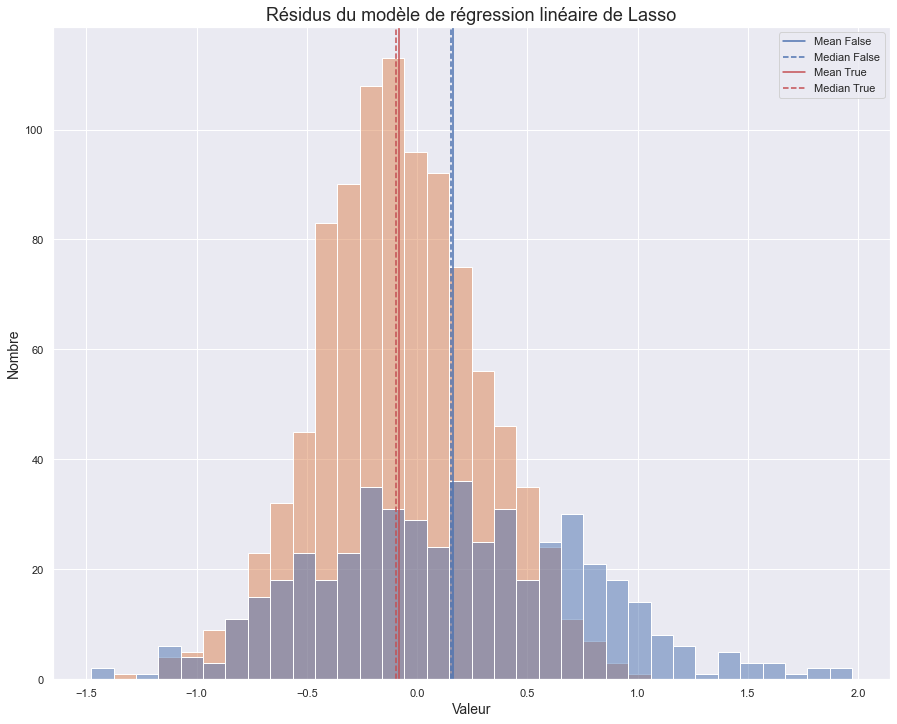

In [127]:
sns.histplot(x='resid_lasso',data= billet_nn,hue='is_genuine' )
plt.title('Résidus du modèle de régression linéaire de Lasso',fontsize = 18)
plt.xlabel('Valeur',fontsize = 14)
plt.ylabel('Nombre',fontsize = 14)
plt.axvline(mean_f,color='b',label='Mean False')
plt.axvline(median_f,color='b',label='Median False',linestyle='--')
plt.axvline(mean_t,color='r',label='Mean True')
plt.axvline(median_t,color='r',label='Median True',linestyle='--')
plt.legend()
plt.show()

Loi Normale dont nous avons confirmation par ce graphique avec les formes en cloches des distributions ainsi que leur médiane et leur moyenne respectives similaires.

Passons maintenant à la régression linéaire multiple classique.

### Régression linéaire multiple classique

In [128]:
import statsmodels.formula.api as smf

In [129]:
reg_multi_t = smf.ols('margin_low~diagonal+height_left+height_right+margin_up+length', data=billet_t).fit()
print('Le coefficient de détermination R² est :',reg_multi_t.rsquared)

Le coefficient de détermination R² est : 0.006446282161596706


R² étant proche de 0, impossible de continuer avec.

Nous allons repasser avec le jeu de données en entier.

In [130]:
reg_multi = smf.ols('margin_low~diagonal+height_left+height_right+margin_up+length', data=billet_nn).fit()
print('Le coefficient de détermination R² est :',reg_multi.rsquared)

Le coefficient de détermination R² est : 0.47955679374144633


Ce coefficient est similaire à celui obtenu pour la régression Lasso. 

Maintenant, nous devons savoir si les coefficients sont significativement différents de 0.

In [131]:
reg_multi.pvalues

Intercept       1.791894e-02
diagonal        7.051693e-03
height_left     3.435643e-05
height_right    3.111115e-09
margin_up       2.478999e-05
length          4.249501e-97
dtype: float64

Normalement, ce modèle nous donne directement les résidus sans que nous ayant à les calculer.

Or nous, nous souhaitons séparer ces résidus suivant si le billet est vrai ou faux.

Nous devrons donc le faire manuellement :

In [132]:
y_predicted = reg_multi.predict(X)
resid = y - y_predicted
billet_nn['resid_multi'] = resid

C:\Users\Elenweii\AppData\Local\Temp\ipykernel_15184\118513186.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  billet_nn['resid_multi'] = resid


In [133]:
shapiro(billet_nn.resid_multi[billet_nn.is_genuine==True]).pvalue

0.5889275670051575

In [134]:
shapiro(billet_nn.resid_multi[billet_nn.is_genuine==False]).pvalue

0.1443103402853012

Nous avons à nouveau des p-valeurs supérieures à 0.05, donc encore deux distributions avec une loi Normale que nous allons confirmer avec le graphique.

In [135]:
mean_f = billet_nn.resid_multi[billet_nn.is_genuine == False].mean()
median_f = billet_nn.resid_multi[billet_nn.is_genuine == False].median()
mean_t = billet_nn.resid_multi[billet_nn.is_genuine == True].mean()
median_t = billet_nn.resid_multi[billet_nn.is_genuine == True].median()

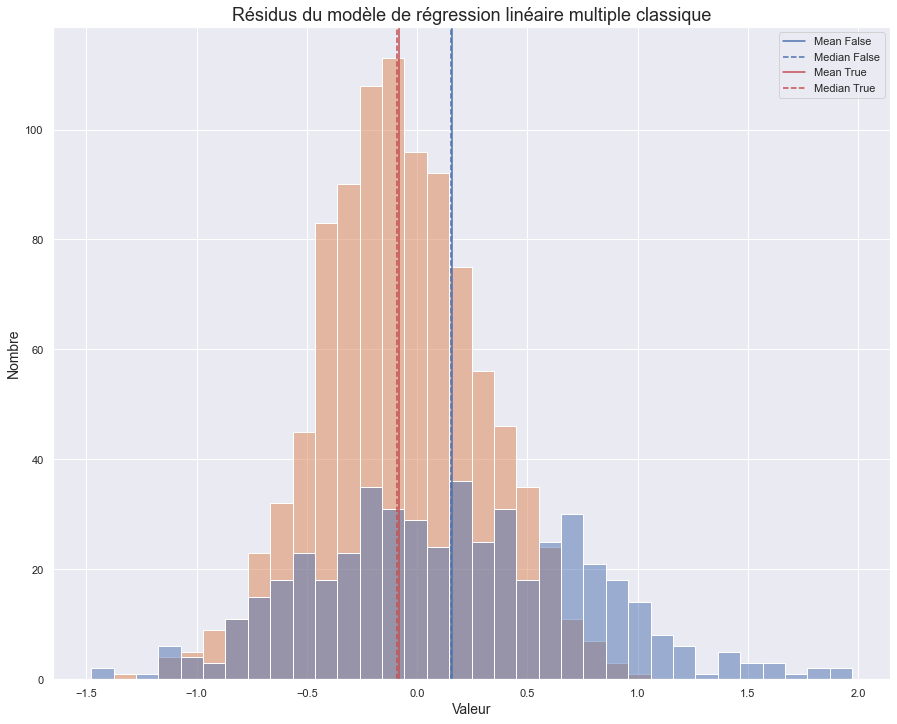

In [136]:
sns.histplot(x='resid_lasso',data= billet_nn,hue='is_genuine' )
plt.title('Résidus du modèle de régression linéaire multiple classique',fontsize = 18)
plt.xlabel('Valeur',fontsize = 14)
plt.ylabel('Nombre',fontsize = 14)
plt.axvline(mean_f,color='b',label='Mean False')
plt.axvline(median_f,color='b',label='Median False',linestyle='--')
plt.axvline(mean_t,color='r',label='Mean True')
plt.axvline(median_t,color='r',label='Median True',linestyle='--')
plt.legend()
plt.show()

Avec toutes ces pvalues inférieures à 0.05, nous pouvons conclure que touts les coefficients sont significativement différents de 0.

Contre toute attente, ce modèle possède un coefficient meilleur (certes, de très peu) à celui obtenu avec la régression Lasso.

Nous allons donc l'utiliser pour retrouver les valeurs manquantes.

# Récupération des valeurs manquantes

In [137]:
billet_n = billet[billet.margin_low.isnull()==True]

In [138]:
X = billet_n.iloc[:,1:]
X = X.drop('margin_low',axis=1)

In [139]:
billet.loc[billet.margin_low.isnull()==True,'margin_low'] = reg_multi.predict(X)

Nous pouvons finalement relancer notre analyse descriptive pour la variable 'margin_low'.

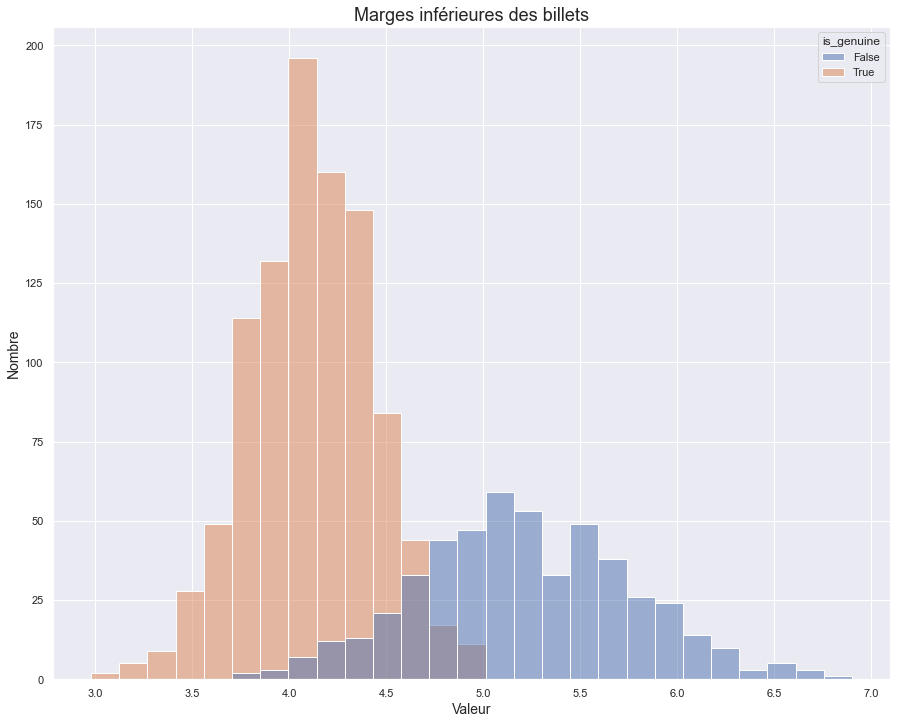

In [140]:
sns.histplot(x='margin_low',data= billet,hue='is_genuine' )
plt.title('Marges inférieures des billets',fontsize = 18)
plt.xlabel('Valeur',fontsize = 14)
plt.ylabel('Nombre',fontsize = 14)
plt.show()

Nous avons de nouveau deux distributions suivant à priori une loi Normale.

Les plages des valeurs sont :

    - de 3.82 à 6.9 pour les faux billets
    - de 2.98 à 4.94 (cette valeur ayant baissée suite à la supression de la valeur aberrante) pour les vrais billets
    
Dans l'ensemble, les plages de valeurs sont les mêmes.

Voyons maintenant les moyennes et les médianes.

In [141]:
mean_f = billet.margin_low[billet.is_genuine == False].mean()
median_f = billet.margin_low[billet.is_genuine == False].median()
mean_t = billet.margin_low[billet.is_genuine == True].mean()
median_t = billet.margin_low[billet.is_genuine == True].median()

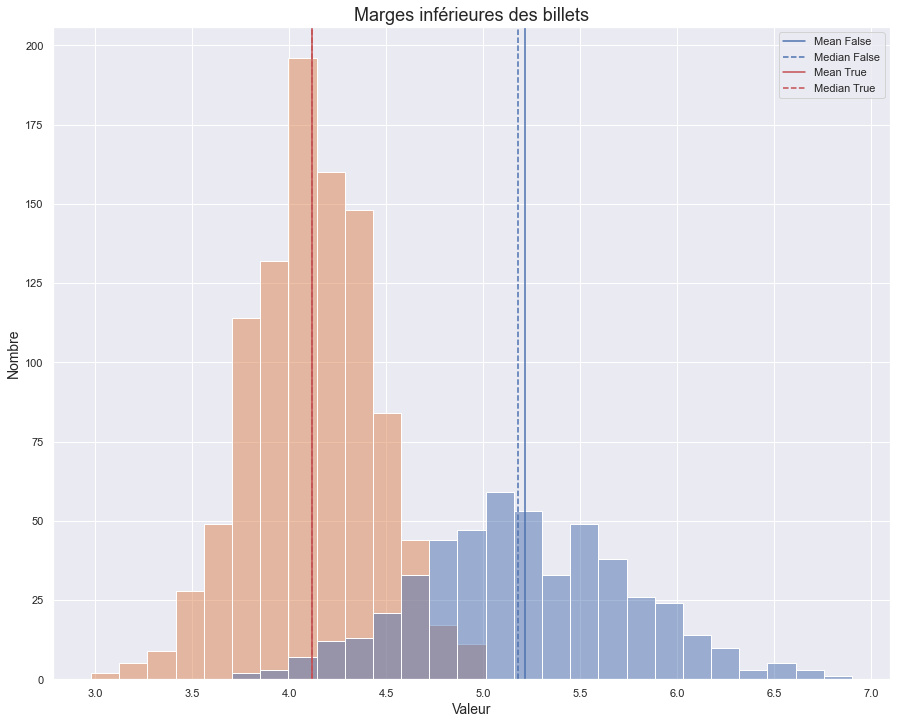

In [142]:
sns.histplot(x='margin_low',data= billet,hue='is_genuine' )
plt.title('Marges inférieures des billets',fontsize = 18)
plt.xlabel('Valeur',fontsize = 14)
plt.ylabel('Nombre',fontsize = 14)
plt.axvline(mean_f,color='b',label='Mean False')
plt.axvline(median_f,color='b',label='Median False',linestyle='--')
plt.axvline(mean_t,color='r',label='Mean True')
plt.axvline(median_t,color='r',label='Median True',linestyle='--')
plt.legend()
plt.show()

Ici, nous observons une similitude entre la moyenne et la médiane de la distribution rouge, en revanche la similitude est moins évidente pour la distribution bleue.

En ce qui concerne les valeurs, nous avons :

    - la moyenne et la médiane de la distribution rouge proches de 4.1 comme avant
    - celles de la distribution bleue sont proches de 5.2 également

Nous pouvons maintenant passer à la partie qui nous intéresse le plus, à savoir les algorithmes de prédictions.

# Algorithmes de prédiction des faux billets

Dans cette partie, nous devons mettre en place deux types d'algorithmes de prédiction :

    - une régression logistique
    - un algorithme impliquant la méthode des k-means avec leur centroïde

# Régression logistique

Le but de la régression logistique est assez similaire à la régression linéaire.

Nous cherchons à expliquer une variable cette fois qualitative (dans notre cas 'is_genuine') par rapport à des variables quantitatives explicatives.

Le but final étant de réaliser des prédictions sur des billets de banques pour savoir s'ils sont vrais ou faux.

Nous allons tout d'abord commencer par créer les jeux d'entrainement et de test pour l'algorithme.

In [143]:
from sklearn.model_selection import train_test_split

In [144]:
training_data, testing_data = train_test_split(billet, random_state=42)

Nous allons ensuite séparer nos variables en X pour les variables explicatives et en Y la variable expliquée.

In [145]:
YTrain = training_data.iloc[:,0]
XTrain = training_data.iloc[:,1:]
print(YTrain.value_counts())

True     760
False    364
Name: is_genuine, dtype: int64


Nous faisons de même pour le jeu test.

In [146]:
YTest = testing_data.iloc[:,0]
XTest = testing_data.iloc[:,1:]
print(YTest.value_counts())

True     239
False    136
Name: is_genuine, dtype: int64


In [147]:
import statsmodels as sm
from statsmodels.api import Logit

Nous pouvons maintenant initier la régression.

In [148]:
lr = Logit(endog=YTrain,exog=XTrain)
res = lr.fit()

Optimization terminated successfully.
         Current function value: 0.033227
         Iterations 11


Ce que nous avons en sortie nous indique le nombre d'itérations qu'il a fallu pour optimiser la log-vraisemblance (dans notre cas, 11 itérations).

In [149]:
print('Le coefficient de détermination du modèle est :',res.prsquared)

Le coefficient de détermination du modèle est : 0.9472364238795237


Nous devons cependant savoir si nos variables ont des coefficients différents de 0.

In [150]:
res.pvalues

diagonal        1.579793e-01
height_left     1.659315e-01
height_right    1.183957e-02
margin_low      2.400461e-08
margin_up       3.191471e-05
length          6.177526e-10
dtype: float64

Comme nous pouvons le voir, deux de nos variables ne sont pas différentes de 0.

Nous allons refaire le modèle en le supprimant.

In [151]:
YTrain_ = training_data.iloc[:,0]
XTrain_ = training_data.iloc[:,3:]
XTrain_

,height_right,margin_low,margin_up,length
808,104.02,4.11,2.97,113.55
1229,104.10,6.05,3.39,111.52
1480,104.66,5.71,3.38,112.33
1436,103.85,5.79,3.37,111.30
179,103.94,4.05,3.04,113.09
...,...,...,...,...
1131,103.44,5.12,3.36,111.49
1295,104.36,5.59,3.61,112.05
861,103.74,4.43,2.90,113.65
1460,104.48,5.27,3.46,110.94


Nous avons bien supprimé les bonnes colonnes du set de training.

Faisons de même pour le set de test.

In [152]:
YTest_ = testing_data.iloc[:,0]
XTest_ = testing_data.iloc[:,3:]
XTest_

,height_right,margin_low,margin_up,length
1117,104.14,4.690000,3.06,112.04
1396,104.23,4.750000,3.34,112.28
422,103.63,4.040000,2.96,112.76
413,103.50,4.159894,3.16,112.95
451,103.54,4.070000,2.78,113.03
...,...,...,...,...
155,103.85,4.360000,2.96,113.22
1151,104.05,4.790000,3.18,111.46
1141,104.35,4.570000,3.52,111.73
975,104.26,4.560000,3.24,112.82


Idem pour ce set.

Nous pouvons refaire le modèle.

In [153]:
lr = Logit(endog=YTrain_,exog=XTrain_)
res = lr.fit()
print('Le coefficient de détermination du modèle est :',res.prsquared)

Optimization terminated successfully.
         Current function value: 0.036338
         Iterations 11
Le coefficient de détermination du modèle est : 0.9422963578476156


Nous pouvons observer que le coefficient est toujours proche de 1 bien qu'il soit légèrement plus faible que précédemment.

Regardons maintenant des coefficients des variables.

In [154]:
res.pvalues

height_right    5.205732e-12
margin_low      1.721836e-09
margin_up       5.661761e-06
length          2.024238e-13
dtype: float64

Avec ces valeurs, nous pouvons dire que les coefficients sont différents de 0.

Passons maintenant à la prédiction avec le jeu de test : 

In [155]:
predProbaSm = res.predict(XTest_)
# Nous réalisons la prédiction

In [156]:
import numpy as np

In [157]:
predSm = np.where(predProbaSm > 0.5, True, False)
# Nous devons maintenant indiquer pour quelles valeurs nous pouvons déclarer qu'un billet peut être considéré comme vrai 
# Nous choisissons comme valeur seuil 0.5 de manière arbitraire

Nous allons maintenant réaliser une matrice de confusion pour ensuite connaitre notre taux de succès dans la prédiction ainsi que son taux d'erreur.

In [158]:
mcSm = pd.crosstab(YTest_,predSm)
mcSm

col_0,False,True
is_genuine,,
False,134,2
True,0,239


Nous pouvons constater que nous avons 2 faux positifs (2 faux billets considérés par l'algorithme comme de vrais billets) contre 134 faux négatifs (les faux billets considérés comme des faux par l'algorithme).

In [159]:
faux_positif = round((mcSm.iloc[0,1] / mcSm.iloc[0,:].sum())*100,2)
print('Nous avons ',faux_positif,'% de faux positifs')

Nous avons  1.47 % de faux positifs


Nous pouvons même aller plus loin :

In [160]:
mcSmNumpy = mcSm.values
accSm = np.sum(np.diagonal(mcSmNumpy))/np.sum(mcSmNumpy)
print("Taux de reconnaissance : %.4f" % (accSm))
errSm = 1.0 - accSm 
print("Taux d'erreur' : %.4f" % (errSm))

Taux de reconnaissance : 0.9947
Taux d'erreur' : 0.0053


Avec un taux de succès à 99,5 % et un taux d'erreur à 0.5 %, nous pouvons conclure que cet algorithme est très performant quand à la détection des faux billets.

Nous allons maintenant passer à la construction de la courbe ROC.

In [161]:
import sklearn.metrics as metrics

In [162]:
fprSm, tprSm, _ = metrics.roc_curve(YTest_,predProbaSm,pos_label=1)

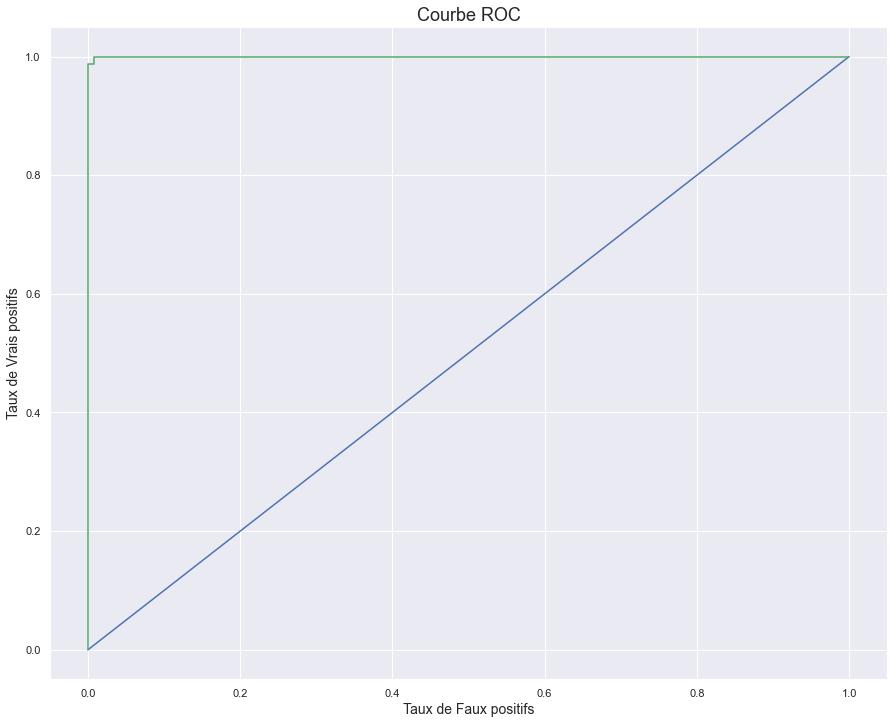

In [163]:
plt.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1),'b')
plt.plot(fprSm,tprSm,"g")
plt.title("Courbe ROC",fontsize= 18)
plt.xlabel('Taux de Faux positifs', fontsize = 14)
plt.ylabel('Taux de Vrais positifs', fontsize = 14)
plt.show()

Grâce à cette courbe, nous pouvons maintenant calculer l'aire entre la courbe et la diagonale.

Plus cette aire est proche de 1, meilleur est l'algorithme car plus facilement il différencit les vrais des faux billets.

In [164]:
aucSm = metrics.roc_auc_score(YTest_,predProbaSm)
aucSm

0.999907703667241

Avec une AUC proche de 1, nous pouvons conclure que le modèle prédit correctement l'appartenance des billets à un groupe (vrai ou faux).

# Méthode des Kmeans

Le but de cette méthode est de prédire l'appartenance des billets inconnus en fonctions des centroïdes obtenus avec le jeu de données des billets connus.

In [165]:
from sklearn.cluster import KMeans

Nous allons réutiliser XTrain, YTrain, XTest, YTest que nous avons créés pour la régression logistique.

In [166]:
kmeans = KMeans(n_clusters=2,random_state=42)
kmeans.fit(XTrain,YTrain)

KMeans(n_clusters=2, random_state=42)

Nous lançons notre prédiction :

In [167]:
km = kmeans.predict(XTest, YTest)

Maintenant, il faut déterminer quelle valeur représente les vrais billets.

Pour ce faire, nous allons compter les valeurs disponibles dans 'km'.

In [168]:
km_ = pd.DataFrame(km)
# Nous devons d'abord transformer km en dataframe pour utiliser la méthode suivante

In [169]:
predkm = np.where(km > 0.5, False, True)

Nous créons notre matrice de confusion :

In [170]:
mckm = pd.crosstab(YTest,predkm)
mckm

col_0,False,True
is_genuine,,
False,131,5
True,0,239


Ici par contre, nous avons 5 faux positifs contre 131 faux négatifs.

In [171]:
faux_positif = round((mckm.iloc[0,1] / mckm.iloc[0,:].sum())*100,2)
print('Nous avons ',faux_positif,'% de faux positifs')

Nous avons  3.68 % de faux positifs


Nous avons donc un pourcentage de faux positifs plus de 2 fois plus important que pour la régression logistique.

Nous pouvons maintenant calculer notre taux de succès et notre taux d'erreur.

In [172]:
mckmNumpy = mckm.values
acckm = np.sum(np.diagonal(mckmNumpy))/np.sum(mckmNumpy)
print("Taux de reconnaissance : %.4f" % (acckm))
errkm = 1.0 - acckm 
print("Taux d'erreur' : %.4f" % (errkm))

Taux de reconnaissance : 0.9867
Taux d'erreur' : 0.0133


Avec 98,7 % de réussite et 1,3 % d'erreurs, ce modèle est légèrement moins précis que celui de la régression linéaire.

# Utilisation des algorithmes pour de nouveaux jeux de données

Nous allons commencer par charger le jeu de données et voir à quoi il ressemble.

In [173]:
test = pd.read_csv('billets_production.csv')
test

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


Une nouvelle variable est présente, celle qui identifie les billets.

Pour les prédictions, celle-ci ne fera que nous géner, nous allons donc la supprimer.

In [174]:
test_ = test.drop('id',axis=1)

## La régression logistique

Pour rappel, nous devons supprimer deux variables ('diagonal' et 'height_left') à la dataframe pour que l'algorithme fonctionne.

In [175]:
test_res = test_.drop(['diagonal','height_left'],axis=1)

Nous réalisons maintenant notre prédiction :

In [176]:
faux = res.predict(test_res)

Nous devons maintenant indiquer pour quelles valeurs nous pouvons déclarer qu'un billet peut être considéré comme vrai.


Nous choisissons comme valeur seuil toujours 0.5

In [177]:
pred = np.where(faux > 0.5, True, False)

Nous allons maintenant rajouter les prédictions à la dataframe et observer les résultats.

In [178]:
test_res = test
test_res['pred'] = pred
test_res

,diagonal,height_left,height_right,margin_low,margin_up,length,id,pred
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,False
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,False
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,False
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,True
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,True


Nous avons maintenant identifier les vrais billets des faux (3 Faux contre 2 Vrais).

## La méthode des k-means

Passons maintenant à la méthode des k-means.

In [179]:
faux_km = kmeans.predict(test_)

In [180]:
pred_km = np.where(faux_km > 0.5, False, True)

In [181]:
test_km = test
test_km['pred'] = pred_km
test_km

,diagonal,height_left,height_right,margin_low,margin_up,length,id,pred
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,False
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,False
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,False
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,True
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,True


Nous retrouvons bien les mêmes résultats que pour la régression logistique (3 Faux et 2 Vrais).

# Conclusion

Pour conclure, nous allons dire que la régression logistique et la méthode des k-means ont montré de bon résultats, bien que ceux de la régression logistique soient techniquement meilleurs que ceux du k-means et donc à privilégier.

En ce qui concerne la qualité des données, nous pouvons dire qu'il manque une variable d'identification des billets, autrement dit, la clé primaire du jeu de données.